# ETL — Section  
**Objectif :** construire un dataset unique (2019–2025) propre et cohérent.

## 1 — ETL
Regroupe l’ensemble du pipeline d’ingestion et de préparation.

### 1.1 — Collecte saisons 2019–2025
Charger la table de données depuis Github et gestion des données saisons

In [102]:
import pandas as pd
import numpy as np
import re

PATH_XLSX = "https://raw.githubusercontent.com/CedrikCampeau31/STATS_SPORTS/main/STATS_NHL_ALL_19_25.xlsx"
df_raw = pd.read_excel(PATH_XLSX, sheet_name=0, skiprows=1, engine="openpyxl")

print("Shape brut:", df_raw.shape)
print("Aperçu colonnes brutes:", list(df_raw.columns))

df = df_raw.copy()

Shape brut: (1800, 51)
Aperçu colonnes brutes: ['Rk', 'Name', 'Team', 'Age', 'Pos', 'GP', 'G', 'A', 'P', 'PIM', '+/-', 'TOI', 'ES', 'PP', 'SH', 'ESG', 'PPG', 'SHG', 'GWG', 'OTG', 'ESA', 'PPA', 'SHA', 'GWA', 'OTA', 'ESP', 'PPP', 'SHP', 'GWP', 'OTP', 'PPP%', 'G/60', 'A/60', 'P/60', 'ESG/60', 'ESA/60', 'ESP/60', 'PPG/60', 'PPA/60', 'PPP/60', 'G/GP', 'A/GP', 'P/GP', 'SHOTS', 'SH%', 'HITS', 'BS', 'FOW', 'FOL', 'FO%', 'Season']


### 1.2 — Harmonisation colonnes/typage
Renommer vers un schéma canonique, convertir pourcentages, parser TOI en minutes.

In [103]:
rename_map = {
    "Rk": "rank",
    "Name": "playerName",
    "Team": "team",
    "Age": "age",
    "Pos": "pos",
    "GP": "gp",
    "G": "g",
    "A": "a",
    "P": "pts",
    "PIM": "pim",
    "+/-": "pm",
    "TOI": "toi",
    "ES": "es_pts",
    "PP": "pp_pts",
    "SH": "sh_pts",
    "ESG": "esg",
    "PPG": "ppg",
    "SHG": "shg",
    "GWG": "gwg",
    "OTG": "otg",
    "ESA": "esa",
    "PPA": "ppa",
    "SHA": "sha",
    "GWA": "gwa",
    "OTA": "ota",
    "ESP": "esp",
    "PPP": "ppp",
    "SHP": "shp",
    "GWP": "gwp",
    "OTP": "otp",
    "PPP%": "ppp_pct",
    "G/60": "g_per60",
    "A/60": "a_per60",
    "P/60": "p_per60",
    "ESG/60": "esg_per60",
    "ESA/60": "esa_per60",
    "ESP/60": "esp_per60",
    "PPG/60": "ppg_per60",
    "PPA/60": "ppa_per60",
    "PPP/60": "ppp_per60",
    "G/GP": "g_pergp",
    "A/GP": "a_pergp",
    "P/GP": "p_pergp",
    "SHOTS": "shots",
    "SH%": "sh_pct",
    "HITS": "hits",
    "BS": "blocks",
    "FOW": "fow",
    "FOL": "fol",
    "FO%": "fo_pct",
    "Season": "seasonId",
}
df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

# Selection des colonnes pouvant être pertinente
keep_cols = [c for c in [
    "rank","playerName","team","age","pos","seasonId",
    "gp","g","a","pts","pim","pm","toi","es_pts","pp_pts","sh_pts",
    "esg","ppg","shg","gwg","otg","esa","ppa","sha","gwa","ota","esp","ppp","shp","gwp","otp",
    "ppp_pct",
    "g_per60","a_per60","p_per60","esg_per60","esa_per60","esp_per60","ppg_per60","ppa_per60","ppp_per60",
    "g_pergp","a_pergp","p_pergp",
    "shots","sh_pct","hits","blocks","fow","fol","fo_pct"
] if c in df.columns]
df = df[keep_cols].copy()

# Saison en int
if 'seasonId' in df.columns:
    df['seasonId'] = df['seasonId'].fillna(0).astype(int)

#  Pourcentages en numériques
for pct_col in ["sh_pct", "fo_pct", "ppp_pct"]:
    if pct_col in df.columns:
        df[pct_col] = pd.to_numeric(df[pct_col].astype(str).str.replace('%','', regex=False), errors='coerce')

# Numérisation
num_cols = [c for c in df.columns if c not in ["playerName","team","pos","toi","seasonId"]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# TOI conversion
def toi_to_minutes(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    s = str(x)
    if re.match(r"^\d{1,2}:\d{2}:\d{2}$", s):
        h, m, sec = s.split(":")
        return int(h)*60 + int(m) + int(sec)/60.0
    if re.match(r"^\d{1,3}:\d{2}$", s):
        m, sec = s.split(":")
        return int(m) + int(sec)/60.0
    return np.nan

if "toi" in df.columns:
    df["toi_min_total"] = df["toi"].apply(toi_to_minutes)

### 1.3 — Nettoyage & intégration
Nettoyage valeurs manquantes / trimming / uppercase équipes-positions; typage numérique; filtres essentiels.

In [104]:
#-- Nettoyage final ---
if "team" in df.columns:
    df["team"] = df["team"].astype(str).str.strip().str.upper()
if "pos" in df.columns:
    df["pos"]  = df["pos"].astype(str).str.strip().str.upper()
df = df.dropna(subset=["playerName","team"])
df = df[df["gp"].fillna(0) >= 0]

print("Shape nettoyé:", df.shape)

def _find_col(df, candidates):
    # matching robuste: ignore casse / espaces / underscores
    norm = {re.sub(r'[\s_]+','', str(c)).lower(): c for c in df.columns}
    for cand in candidates:
        key = re.sub(r'[\s_]+','', cand).lower()
        if key in norm:
            return norm[key]
    # fallback
    for cand in candidates:
        key = re.sub(r'[\s_]+','', cand).lower()
        for k, orig in norm.items():
            if key in k:
                return orig
    return None

def ensure_season_cols(df: pd.DataFrame):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]

    # 1) Saisir/normaliser la saison
    season_col = _find_col(df, ['seasonId','season_id','season','Season'])
    if season_col is None:
        raise ValueError("Pas de colonne saison trouvée (season/seasonId).")
    if season_col != 'seasonId':
        df = df.rename(columns={season_col: 'seasonId'})

    # si la saison est du texte type "2021-22", on la laisse comme ca, j'ai eu quelque probleme initialement.
    try:
        df['seasonId'] = pd.to_numeric(df['seasonId'], errors='ignore')
    except Exception:
        pass

    # Identifiant joueur
    player_col = _find_col(df, [
        'playerId','player_id','skaterId','nhlId',
        'playerName','Player Name','Name','name','player'
    ])
    if player_col is None:
        raise ValueError(
            "Aucun identifiant joueur trouvé (ex. playerId, playerName, Name). "
            f"Colonnes vues: {list(df.columns)[:20]} ..."
        )

    # Créer seasonId_prev intra-joueur
    df = df.sort_values([player_col, 'seasonId'])
    if 'seasonId_prev' not in df.columns:
        df['seasonId_prev'] = df.groupby(player_col)['seasonId'].shift(1)

    return df, player_col

# Apllciation
df, PLAYER_COL = ensure_season_cols(df)

# Features *_prev et deltas par joueur
stat_cols = [c for c in [
    'gp','g','a','pts','shots','hits','blocks','fo_pct', 'sh_pct', 'pm','pim',
    'g_per60','a_per60','p_per60','esp','ppp','shp','toi_min_total', "sh_pct"
] if c in df.columns]

for col in stat_cols:
    df[f'{col}_prev'] = df.groupby(PLAYER_COL)[col].shift(1)
    df[f'd_{col}'] = df[col] - df[f'{col}_prev']

print("PLAYER_COL =", PLAYER_COL)
print("OK: seasonId_prev + features prev/deltas créés.")
print("Exemples colonnes prev:", [c for c in df.columns if c.endswith('_prev')][:10])

# Petit échantillon de contrôle sur le joueur
try:
    sample_player = df[PLAYER_COL].mode().iat[0]
    print("Exemple joueur:", sample_player)
    print(
        df[df[PLAYER_COL]==sample_player]
          .sort_values('seasonId')[['seasonId','pts','pts_prev','d_{0}'.format('pts')]]
          .head(10)
    )
except Exception as e:
    print("Aperçu joueur impossible:", e)


df["team_id"] = df["team"].astype("category").cat.codes

teams_map_df = (
    df[["team","team_id"]]
    .drop_duplicates()
    .sort_values("team_id")
    .reset_index(drop=True)
)
print(teams_map_df.head(32))

Shape nettoyé: (1800, 52)
PLAYER_COL = playerName
OK: seasonId_prev + features prev/deltas créés.
Exemples colonnes prev: ['seasonId_prev', 'gp_prev', 'g_prev', 'a_prev', 'pts_prev', 'shots_prev', 'hits_prev', 'blocks_prev', 'fo_pct_prev', 'sh_pct_prev']
Exemple joueur: Adam Fox
      seasonId  pts  pts_prev  d_pts
1625    201920   42       NaN    NaN
1238    202021   47      42.0    5.0
945     202122   74      47.0   27.0
656     202223   72      74.0   -2.0
344     202324   73      72.0    1.0
81      202425   61      73.0  -12.0
   team  team_id
0   ANA        0
1   ARI        1
2   BOS        2
3   BUF        3
4   CAR        4
5   CBJ        5
6   CGY        6
7   CHI        7
8   COL        8
9   DAL        9
10  DET       10
11  EDM       11
12  FLA       12
13  LAK       13
14  MIN       14
15  MTL       15
16  NJD       16
17  NSH       17
18  NYI       18
19  NYR       19
20  OTT       20
21  PHI       21
22  PIT       22
23  SEA       23
24  SJS       24
25  STL       25
26

### 1.4 — Export dataset propre
Sauvegarder la version “clean” et les artefacts utiles (ex.: mapping des équipes).

**Jalon – Fin ETL** : dataset propre disponible pour l’EDA.

# EDA — Section  
**Objectif :** qualifier la qualité des données, détecter les outliers et dériver des variables de base.

## 2 — EDA
Cadre global des analyses exploratoires.

### 2.1 — Qualité des données
Stats descriptives, audit.

In [105]:
%pip install -q xlsxwriter openpyxl


In [106]:
import os, numpy as np, pandas as pd, openpyxl, xlsxwriter
BASE_OUT = "artifacts_eda"
os.makedirs(BASE_OUT, exist_ok=True)


def first_present(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# normalise un nom de colonne pour affichage propre
def nice(col):
    return str(col)

# Mapping canoniques (IA utilisé pour générer ceci, car j'avais une erreur de nommage et je ne la trouvais pas (cap))
col_candidates = {
    "gp": ["gp","GP","gamesPlayed","games_played"],
    "g": ["g","G","goals"],
    "a": ["a","A","assists"],
    "pts": ["pts","P","points"],
    "pim": ["pim","PIM"],
    "pm": ["+/-","pm","plus_minus"],
    "es_pts": ["es_pts","ES PTS","ES-PTS","ESP","even_strength_points"],
    "pp_pts": ["pp_pts","PPP","PP PTS","PP-PTS","pp_points"],
    "sh_pts": ["sh_pts","SHP","SH PTS","SH-PTS","sh_points"],
    "esg": ["ESG","esg"],
    "ppg": ["PPG","ppg"],
    "shg": ["SHG","shg"],
    "gwg": ["GWG","gwg"],
    "otg": ["OTG","otg"],
    "esa": ["ESA","esa"],
    "ppa": ["PPA","ppa"],
    "sha": ["SHA","sha"],
    "gwa": ["GWA","gwa"],
    "ota": ["OTA","ota"],
    "esp": ["ESP","esp"],
    "ppp": ["PPP","ppp"],
    "shp": ["SHP","shp"],
    "gwp": ["GWP","gwp"],
    "otp": ["OTP","otp"],
    "ppp_pct": ["PPP%","ppp%","ppp_pct"],
    "g_per60": ["G/60","g_per60"],
    "a_per60": ["A/60","a_per60"],
    "p_per60": ["P/60","p_per60"],
    "esg_per60": ["ESG/60","esg_per60"],
    "esa_per60": ["ESA/60","esa_per60"],
    "esp_per60": ["ESP/60","esp_per60"],
    "ppg_per60": ["PPG/60","ppg_per60"],
    "ppa_per60": ["PPA/60","ppa_per60"],
    "ppp_per60": ["PPP/60","ppp_per60"],
    "g_pergp": ["G/GP","g_pergp"],
    "a_pergp": ["A/GP","a_pergp"],
    "p_pergp": ["P/GP","p_pergp"],
    "shots": ["SHOTS","shots","S"],
    "sh_pct": ["SH%","Sh%","sh%","sh_pct"],
    "hits": ["HITS","hits"],
    "blocks": ["BS","BLOCKS","blocks","blk","bs"],
    "fow": ["FOW","fow"],
    "fol": ["FOL","fol"],
    "fo_pct": ["FO%","fo%","fo_pct"],
    "toi_min_total": ["TOI (min)","TOI","toi","toi_min_total"],
}

# colonnes d'identité
name_col = first_present(df, ["playerName","Player","Name","name"])
team_col = first_present(df, ["team","Team"])
pos_col  = first_present(df, ["pos","Pos","position","Position"])
age_col  = first_present(df, ["age","Age"])

id_cols = [c for c in [name_col, team_col, pos_col, age_col] if c is not None]

# Résout les noms réels présents dans df
resolved = {}
for canon, cands in col_candidates.items():
    real = first_present(df, cands)
    if real is not None:
        resolved[canon] = real

audit_cols = list(resolved.values())

# conversion numérique - audit
for col in audit_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

#  Règles métier
def business_rule_flags(series, col_canon):
    s = series
    rule = pd.Series(False, index=s.index)

    if col_canon == "sh_pct":
        rule = rule | (s > 35)
    if col_canon == "pts":
        rule = rule | (s > 170)
    if col_canon == "gp":
        rule = rule | (s > 90)
    if col_canon == "toi_min_total":
        rule = rule | (s > 2000)

    return rule

### 2.2 — Détection outliers
Détection IQR/Z + règles métier, marquage des lignes, exports CSV/XLSX.

In [107]:

def iqr_bounds(x, k=1.5):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (q1 - k*iqr, q3 + k*iqr, q1, q3, iqr)

out_rows = []
percol_stats = []
flag_cols_added = []

# red flag
any_outlier_global = pd.Series(False, index=df.index)

for canon, real in resolved.items():
    s = df[real]
    x = s.dropna()
    if x.empty:
        continue

    low, high, q1, q3, iqr = iqr_bounds(x, k=1.5)
    mean = x.mean()
    std  = x.std(ddof=0)
    z = (s - mean) / (std if (std and std > 0) else np.nan)

    iqr_flag = (s < low) | (s > high)
    z_flag   = z.abs() >= 3
    rule_flag = business_rule_flags(s, canon)
    any_flag = iqr_flag | z_flag | rule_flag
    any_outlier_global = any_outlier_global | any_flag.fillna(False)

    flag_colname = f"flag_outlier__{canon}"
    df[flag_colname] = any_flag.astype("boolean")
    flag_cols_added.append(flag_colname)

    # listing long
    flagged_idx = any_flag[any_flag.fillna(False)].index
    if len(flagged_idx) > 0:
        flagged = df.loc[flagged_idx, id_cols + [real]].copy() if id_cols else df.loc[flagged_idx, [real]].copy()
        flagged["outlier_col_canon"] = canon
        flagged["outlier_col_name"]  = real
        flagged["value"] = s.loc[flagged_idx].values
        flagged["flag_iqr"]  = iqr_flag.loc[flagged_idx].astype(bool).values
        flagged["flag_z3"]   = z_flag.loc[flagged_idx].astype(bool).values
        flagged["flag_rule"] = rule_flag.loc[flagged_idx].astype(bool).values
        for extra in ["gp","g","a","pts","toi_min_total","shots","sh_pct","fo_pct"]:
            ex_real = resolved.get(extra, None)
            if ex_real is not None and ex_real not in flagged.columns:
                flagged[extra] = df.loc[flagged_idx, ex_real].values

        out_rows.append(flagged)

    # stats par colonne
    n = s.shape[0]
    n_na = s.isna().sum()
    n_iqr = int(iqr_flag.fillna(False).sum())
    n_z3  = int(z_flag.fillna(False).sum())
    n_rule= int(rule_flag.fillna(False).sum())
    n_any = int(any_flag.fillna(False).sum())

    percol_stats.append({
        "column_canon": canon,
        "column_name": real,
        "count": int(n - n_na),
        "n_missing": int(n_na),
        "min": float(x.min()),
        "q1": float(q1),
        "median": float(x.median()),
        "q3": float(q3),
        "max": float(x.max()),
        "mean": float(mean),
        "std_pop": float(std) if pd.notna(std) else np.nan,
        "iqr": float(iqr),
        "iqr_low": float(low),
        "iqr_high": float(high),
        "n_outliers_iqr": n_iqr,
        "pct_outliers_iqr": float(100*n_iqr/max(1, n-n_na)),
        "n_outliers_z>=3": n_z3,
        "pct_outliers_z>=3": float(100*n_z3/max(1, n-n_na)),
        "n_outliers_rule": n_rule,
        "n_outliers_any": n_any,
        "pct_outliers_any": float(100*n_any/max(1, n-n_na)),
        "has_extreme_values": bool(n_any > 0)
    })

df["flag_outlier__ANY"] = any_outlier_global.astype("boolean")

# DataFrames finaux
outliers_long = (
    pd.concat(out_rows, ignore_index=True)
    if out_rows else
    pd.DataFrame(columns=(id_cols + ["outlier_col_canon","outlier_col_name","value","flag_iqr","flag_z3","flag_rule"]))
)

summary = (
    outliers_long.groupby(["outlier_col_canon","outlier_col_name"]).size()
    .reset_index(name="n_outliers")
    .sort_values("n_outliers", ascending=False)
    if len(outliers_long) else
    pd.DataFrame(columns=["outlier_col_canon","outlier_col_name","n_outliers"])
)

percol_df = pd.DataFrame(percol_stats).sort_values(["pct_outliers_any","pct_outliers_iqr","pct_outliers_z>=3"], ascending=False)

# Écriture fichiers
csv_listing = os.path.join(BASE_OUT, "outliers_listing_long.csv")
csv_summary = os.path.join(BASE_OUT, "outliers_summary.csv")
csv_stats   = os.path.join(BASE_OUT, "outliers_per_column_stats.csv")
csv_df      = os.path.join(BASE_OUT, "dataset_with_outlier_flags.csv")
xlsx_path   = os.path.join(BASE_OUT, "outliers_report.xlsx")

outliers_long.to_csv(csv_listing, index=False)
summary.to_csv(csv_summary, index=False)
percol_df.to_csv(csv_stats, index=False)
df.to_csv(csv_df, index=False)

try:
    with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as xl:
        outliers_long.to_excel(xl, "outliers_listing", index=False)
        summary.to_excel(xl, "summary", index=False)
        percol_df.to_excel(xl, "per_column_stats", index=False)
except Exception as e:
    print(f"[Info] Impossible d'écrire le Excel (lib manquante ?): {e}")

# Affichage terminal
print("\n=== Résumé outliers (par colonne) ===")
print(summary.head(30).to_string(index=False))
print("\n=== Analyse statistique (top 15 par % outliers) ===")
cols_show = ["column_canon","column_name","count","n_missing","min","q1","median","q3","max",
             "mean","std_pop","iqr_low","iqr_high","n_outliers_any","pct_outliers_any"]
print(percol_df[cols_show].head(15).to_string(index=False))

print("\nFichiers écrits:")
print(csv_listing)
print(csv_summary)
print(csv_stats)
print(csv_df)
print(xlsx_path)


=== Résumé outliers (par colonne) ===
outlier_col_canon outlier_col_name  n_outliers
              shp              shp         213
           blocks           blocks         137
              ota              ota         128
              shg              shg          84
             hits             hits          77
              sha              sha          64
              ppg              ppg          61
              pim              pim          58
                a                a          51
              fow              fow          51
              otg              otg          50
              pts              pts          49
              gwg              gwg          49
              ppa              ppa          48
                g                g          47
              esp              esp          47
          a_pergp          a_pergp          45
            shots            shots          42
          p_pergp          p_pergp          38
              esa    

**Jalon – Fin EDA** : rapports EDA exportés + dataset enrichi prêt pour la sélection.

# 3- Hypothèses  
**Objectif :** formuler et tester rapidement des intuitions statistiques indépednant des autres tests éffectués.

### H1 - H13

In [108]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error


ALPHA = 0.05

pts_t_col      = "pts"
pts_prev_col   = "pts_prev"
toi_prev_col   = "toi_min_total_prev"
age_col        = "age"
shpct_prev_col = "sh_pct_prev"
gp_prev_col    = "gp_prev"
p60_prev_col   = "p_per60_prev"
dpts_col       = "d_pts"
dg_col         = "d_g"
da_col         = "d_a"
position_col   = "pos"
pp_prev_col    = "ppp_prev"
shots_prev_col = "shots_prev"
level_col      = None

def run_ols(df, y_col, x_cols):
    """Petit OLS maison (y ~ X)."""
    cols = [y_col] + x_cols
    data = df[cols].dropna()
    if data.empty:
        raise ValueError(f"Aucune donnée exploitable pour {cols}")
    X = sm.add_constant(data[x_cols])
    y = data[y_col]
    model = sm.OLS(y, X).fit()
    return model


def nested_model_test(df, y_col, base_cols, extra_cols):
    """
    Compare deux modèles imbriqués :
    - base : y ~ base_cols
    - full : y ~ base_cols + extra_cols
    Retourne le test F + R².
    """
    cols = [y_col] + base_cols + extra_cols
    data = df[cols].dropna()
    if data.empty:
        raise ValueError(f"Aucune donnée pour le test imbriqué sur {cols}")

    y = data[y_col]
    X_base = sm.add_constant(data[base_cols])
    X_full = sm.add_constant(data[base_cols + extra_cols])

    m_base = sm.OLS(y, X_base).fit()
    m_full = sm.OLS(y, X_full).fit()

    F, p, df_diff = m_full.compare_f_test(m_base)

    return {
        "F": float(F),
        "p_value": float(p),
        "df_diff": int(df_diff),
        "R2_base": float(m_base.rsquared),
        "R2_full": float(m_full.rsquared),
        "adjR2_base": float(m_base.rsquared_adj),
        "adjR2_full": float(m_full.rsquared_adj),
    }


def mae_ols(df, y_col, x_cols):
    """MAE in-sample d’un OLS simple."""
    cols = [y_col] + x_cols
    data = df[cols].dropna()
    if data.empty:
        raise ValueError(f"Aucune donnée pour MAE OLS sur {cols}")
    X = sm.add_constant(data[x_cols])
    y = data[y_col]
    model = sm.OLS(y, X).fit()
    y_hat = model.predict(X)
    mae = mean_absolute_error(y, y_hat)
    return float(mae), model


def mae_segmented(df, y_col, x_cols, segment_cols):
    """
    MAE moyen quand on entraîne un OLS par segment (ex. pos, pos×niveau).
    On fait la moyenne des MAE de chaque groupe.
    """
    maes = []
    for seg_vals, group in df.groupby(segment_cols):
        data = group[[y_col] + x_cols].dropna()
        # on évite les mini-segments tout cassés
        if len(data) < len(x_cols) + 3:
            continue
        X = sm.add_constant(data[x_cols])
        y = data[y_col]
        model = sm.OLS(y, X).fit()
        y_hat = model.predict(X)
        maes.append(mean_absolute_error(y, y_hat))

    if len(maes) == 0:
        return np.nan
    return float(np.mean(maes))


# tous les résultats
results = []


def add_result(h_id, H0, H1, test_type,
               var_or_model,
               stat=None, p_value=None,
               extra=None,
               reject=None):
    """Helper pour pousser un résultat dans `results`."""
    results.append({
        "Hypothese": h_id,
        "H0": H0,
        "H1": H1,
        "Test": test_type,
        "Variable/Modèle": var_or_model,
        "Statistique": stat,
        "p_value_2cotes": p_value,
        "Decision_5pct": reject,
        "Details": extra
    })


# H1 : TOI_prev -> pts (effet positif ?)

m_h1 = run_ols(df, pts_t_col, [toi_prev_col])
coef = float(m_h1.params[toi_prev_col])
p = float(m_h1.pvalues[toi_prev_col])
direction_ok = coef > 0
reject = (p < ALPHA) and direction_ok

add_result(
    h_id="H1",
    H0="L’effet de TOI_prev sur pts est nul.",
    H1="TOI_prev a un effet positif sur pts.",
    test_type="Régression OLS (coef TOI_prev)",
    var_or_model=toi_prev_col,
    stat=coef,
    p_value=p,
    extra=f"R2={m_h1.rsquared:.3f}, coef>0 ? {direction_ok}",
    reject=reject
)


# H3 : courbe âge–performance concave ?

df_h3 = df.copy()
df_h3["Age2"] = df_h3[age_col] ** 2
m_h3 = run_ols(df_h3, pts_t_col, [age_col, "Age2"])
coef_age2 = float(m_h3.params["Age2"])
p_age2 = float(m_h3.pvalues["Age2"])
direction_ok = coef_age2 < 0
reject = (p_age2 < ALPHA) and direction_ok

add_result(
    h_id="H3",
    H0="L’âge a un effet linéaire ou nul.",
    H1="La courbe âge–performance est concave (pic).",
    test_type="Régression OLS (Age + Age^2)",
    var_or_model="Age2",
    stat=coef_age2,
    p_value=p_age2,
    extra=f"R2={m_h3.rsquared:.3f}, coef(Age2)<0 ? {direction_ok}",
    reject=reject
)


# H4 : SH%_prev → régression à la moyenne sur ΔPTS ?

m_h4 = run_ols(df, dpts_col, [shpct_prev_col])
coef_sh = float(m_h4.params[shpct_prev_col])
p_sh = float(m_h4.pvalues[shpct_prev_col])
direction_ok = coef_sh < 0
reject = (p_sh < ALPHA) and direction_ok

add_result(
    h_id="H4",
    H0="Le SH%_prev n’affecte pas ΔPTS.",
    H1="SH%_prev élevé → ΔPTS (t − t-1) diminue.",
    test_type="Régression OLS (coef sh_pct_prev)",
    var_or_model=shpct_prev_col,
    stat=coef_sh,
    p_value=p_sh,
    extra=f"R2={m_h4.rsquared:.3f}, coef<0 ? {direction_ok}",
    reject=reject
)


# H5 : FWD vs DEF, à covariables égales

fwd_labels = ["F", "FW", "FWD", "C", "LW", "RW"]
def_labels = ["D", "DEF"]

mask = df[position_col].isin(fwd_labels + def_labels)
df_h5 = df.loc[mask].copy()
df_h5["FWD_dummy"] = df_h5[position_col].isin(fwd_labels).astype(int)
x_h5 = ["FWD_dummy"]

m_h5 = run_ols(df_h5, pts_t_col, x_h5)
coef_pos = float(m_h5.params["FWD_dummy"])
p_pos = float(m_h5.pvalues["FWD_dummy"])
direction_ok = coef_pos > 0
reject = (p_pos < ALPHA) and direction_ok

add_result(
    h_id="H5",
    H0="La position n’a pas d’effet conditionnel.",
    H1="À covariables égales, FWD > DEF en pts.",
    test_type="Régression OLS (dummy FWD vs DEF)",
    var_or_model="FWD_dummy",
    stat=coef_pos,
    p_value=p_pos,
    extra=f"R2={m_h5.rsquared:.3f}, coef>0 ? {direction_ok}",
    reject=reject
)


# H7 : GP_prev apporte quelque chose au-delà de pts_prev ?

m_h7 = run_ols(df, pts_t_col, [pts_prev_col, gp_prev_col])
coef_gp = float(m_h7.params[gp_prev_col])
p_gp = float(m_h7.pvalues[gp_prev_col])
direction_ok = coef_gp > 0
reject = (p_gp < ALPHA) and direction_ok

add_result(
    h_id="H7",
    H0="GP_prev est sans effet propre.",
    H1="GP_prev (assiduité/santé) prédit pts au-delà de pts_prev.",
    test_type="Régression OLS (pts_prev + gp_prev)",
    var_or_model=gp_prev_col,
    stat=coef_gp,
    p_value=p_gp,
    extra=f"R2={m_h7.rsquared:.3f}, coef>0 ? {direction_ok}",
    reject=reject
)


# H8 : P/60_prev ajoute de l’info vs totaux bruts ?

nested_h8 = nested_model_test(
    df,
    pts_t_col,
    base_cols=[pts_prev_col],
    extra_cols=[p60_prev_col]
)
improve_R2 = nested_h8["adjR2_full"] - nested_h8["adjR2_base"]
reject = nested_h8["p_value"] < ALPHA

add_result(
    h_id="H8",
    H0="Les métriques par 60 n’ajoutent rien.",
    H1="p_per60_prev apporte un gain vs totaux bruts.",
    test_type="Test F modèle imbriqué (p_per60_prev)",
    var_or_model="pts ~ pts_prev (+ p_per60_prev)",
    stat=nested_h8["F"],
    p_value=nested_h8["p_value"],
    extra=(
        f"adjR2_base={nested_h8['adjR2_base']:.3f}, "
        f"adjR2_full={nested_h8['adjR2_full']:.3f}, "
        f"ΔadjR2={improve_R2:.3f}"
    ),
    reject=reject
)

# H9 : deltas ΔG, ΔA, ΔPTS → mieux que juste pts_prev ?

nested_h9 = nested_model_test(
    df,
    pts_t_col,
    base_cols=[pts_prev_col],
    extra_cols=[dg_col, da_col, dpts_col]
)
improve_R2 = nested_h9["adjR2_full"] - nested_h9["adjR2_base"]
reject = nested_h9["p_value"] < ALPHA

add_result(
    h_id="H9",
    H0="Les deltas (ΔG, ΔA, ΔPTS) n’aident pas.",
    H1="Les deltas inter-saisons améliorent la prévision.",
    test_type="Test F modèle imbriqué (ΔG, ΔA, ΔPTS)",
    var_or_model="pts ~ pts_prev (+ deltas)",
    stat=nested_h9["F"],
    p_value=nested_h9["p_value"],
    extra=(
        f"adjR2_base={nested_h9['adjR2_base']:.3f}, "
        f"adjR2_full={nested_h9['adjR2_full']:.3f}, "
        f"ΔadjR2={improve_R2:.3f}"
    ),
    reject=reject
)


# H10 : segmentation (Pos × niveau) vs modèle global (MAE)

x_base = [pts_prev_col, age_col, toi_prev_col, gp_prev_col]

df_seg = df.dropna(subset=[pts_t_col] + x_base)

if level_col is None:
    segment_cols = [position_col]
else:
    df_seg = df_seg.dropna(subset=[position_col, level_col])
    segment_cols = [position_col, level_col]

global_mae, _ = mae_ols(df_seg, pts_t_col, x_base)
seg_mae = mae_segmented(df_seg, pts_t_col, x_base, segment_cols)
improvement = global_mae - seg_mae
decision = (seg_mae < global_mae) if not np.isnan(seg_mae) else False

add_result(
    h_id="H10",
    H0="La segmentation ne change rien.",
    H1="Les modèles segmentés (Pos × niveau) baissent la MAE vs le modèle global.",
    test_type="Comparaison MAE (global vs segmenté)",
    var_or_model=f"Global MAE={global_mae:.3f}, Segmenté MAE={seg_mae:.3f}",
    stat=improvement,
    p_value=None,
    extra=f"Gain MAE (global - segmenté) = {improvement:.3f}",
    reject=decision
)

# H11 : interaction TOI_prev × PP_prev ?

df_h11 = df.copy()
df_h11["TOI_PP"] = df_h11[toi_prev_col] * df_h11[pp_prev_col]
m_h11 = run_ols(df_h11, pts_t_col, [toi_prev_col, pp_prev_col, "TOI_PP"])
coef_int = float(m_h11.params["TOI_PP"])
p_int = float(m_h11.pvalues["TOI_PP"])
direction_ok = coef_int > 0
reject = (p_int < ALPHA) and direction_ok

add_result(
    h_id="H11",
    H0="L’interaction TOI×PP est nulle.",
    H1="TOI_prev × PP_prev a un effet positif.",
    test_type="Régression OLS (interaction TOI_prev × PP_prev)",
    var_or_model="TOI_PP",
    stat=coef_int,
    p_value=p_int,
    extra=f"R2={m_h11.rsquared:.3f}, coef>0 ? {direction_ok}",
    reject=reject
)


# H13 : volume de tirs → pts_t (en contrôlant pour PP)

m_h13 = run_ols(df, pts_t_col, [shots_prev_col, pp_prev_col])
coef_shots = float(m_h13.params[shots_prev_col])
p_shots = float(m_h13.pvalues[shots_prev_col])
direction_ok = coef_shots > 0
reject = (p_shots < ALPHA) and direction_ok

add_result(
    h_id="H13",
    H0="Le volume de tirs n’importe pas.",
    H1="SHOTS_prev est positif sur pts_t à PP constant.",
    test_type="Régression OLS (shots_prev + ppp_prev)",
    var_or_model=shots_prev_col,
    stat=coef_shots,
    p_value=p_shots,
    extra=f"R2={m_h13.rsquared:.3f}, coef>0 ? {direction_ok}",
    reject=reject
)

# Résumé + export Excel

results_df = pd.DataFrame(results)
display(results_df)

# Export vers Excel
output_file = "hypothese_result.xlsx"
results_df.to_excel(output_file, index=False)

print(f"\n[OK] Résultats d’hypothèses sauvegardés dans : {output_file}")

,Hypothese,H0,H1,Test,Variable/Modèle,Statistique,p_value_2cotes,Decision_5pct,Details
0,H1,L’effet de TOI_prev sur pts est nul.,TOI_prev a un effet positif sur pts.,Régression OLS (coef TOI_prev),toi_min_total_prev,1.291104e+00,7.388053e-12,True,"R2=0.036, coef>0 ? True"
1,H3,L’âge a un effet linéaire ou nul.,La courbe âge–performance est concave (pic).,Régression OLS (Age + Age^2),Age2,-5.527974e-02,1.157006e-02,True,"R2=0.004, coef(Age2)<0 ? True"
2,H4,Le SH%_prev n’affecte pas ΔPTS.,SH%_prev élevé → ΔPTS (t − t-1) diminue.,Régression OLS (coef sh_pct_prev),sh_pct_prev,-3.687361e-01,1.966798e-03,True,"R2=0.008, coef<0 ? True"
3,H5,La position n’a pas d’effet conditionnel.,"À covariables égales, FWD > DEF en pts.",Régression OLS (dummy FWD vs DEF),FWD_dummy,8.416295e+00,4.368348e-14,True,"R2=0.031, coef>0 ? True"
4,H7,GP_prev est sans effet propre.,GP_prev (assiduité/santé) prédit pts au-delà d...,Régression OLS (pts_prev + gp_prev),gp_prev,-4.482061e-01,6.308260e-27,False,"R2=0.432, coef>0 ? False"
5,H8,Les métriques par 60 n’ajoutent rien.,p_per60_prev apporte un gain vs totaux bruts.,Test F modèle imbriqué (p_per60_prev),pts ~ pts_prev (+ p_per60_prev),6.422931e+01,2.488493e-15,True,"adjR2_base=0.377, adjR2_full=0.407, ΔadjR2=0.029"
6,H9,"Les deltas (ΔG, ΔA, ΔPTS) n’aident pas.",Les deltas inter-saisons améliorent la prévision.,"Test F modèle imbriqué (ΔG, ΔA, ΔPTS)",pts ~ pts_prev (+ deltas),1.625955e+33,0.000000e+00,True,"adjR2_base=0.377, adjR2_full=1.000, ΔadjR2=0.623"
7,H10,La segmentation ne change rien.,Les modèles segmentés (Pos × niveau) baissent ...,Comparaison MAE (global vs segmenté),"Global MAE=11.887, Segmenté MAE=11.252",6.359968e-01,NaN,True,Gain MAE (global - segmenté) = 0.636
8,H11,L’interaction TOI×PP est nulle.,TOI_prev × PP_prev a un effet positif.,Régression OLS (interaction TOI_prev × PP_prev),TOI_PP,1.556699e-02,3.767501e-01,False,"R2=0.342, coef>0 ? True"
9,H13,Le volume de tirs n’importe pas.,SHOTS_prev est positif sur pts_t à PP constant.,Régression OLS (shots_prev + ppp_prev),shots_prev,4.765586e-02,9.540284e-06,True,"R2=0.349, coef>0 ? True"



[OK] Résultats d’hypothèses sauvegardés dans : hypothese_result.xlsx


# Features — Section  
**Objectif :** réduire la redondance, atténuer les extrêmes par saison et retenir un sous-ensemble robuste.

## 4 — Sélection de variables


### 4.1 — Winsorisation par saison
Clip 1%–99% par saison sur les variables numériques.

In [109]:
import os, re, numpy as np, pandas as pd

BASE_OUT = "featuredselect"
os.makedirs(BASE_OUT, exist_ok=True)
def first_present(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Colonnes clés
season_col = first_present(df, ["seasonId","season","Season"])
pos_col    = first_present(df, ["pos","Pos","position","Position"])
pts_col    = first_present(df, ["pts","points","P","Points"])
assert season_col is not None, "Colonne saison manquante (seasonId)."
assert pts_col is not None,    "Colonne des points (pts) manquante."

# Nettoie position
if pos_col:
    df[pos_col] = df[pos_col].astype(str).str.strip().str.upper()

# Winsorisation par saison (corrige Deprecation + booleans)
from pandas.api.types import is_numeric_dtype, is_bool_dtype

def winsorize_by_season(s: pd.Series, season: pd.Series, q_low=0.01, q_high=0.99):
    x = pd.to_numeric(s, errors="coerce")
    tmp = pd.DataFrame({"x": x, "season": pd.to_numeric(season, errors="coerce")})

    def _w(xser: pd.Series):
        xser = pd.to_numeric(xser, errors="coerce")
        if xser.notna().sum() < 5:
            return xser
        qs = xser.quantile([q_low, q_high])
        lo, hi = qs.iat[0], qs.iat[1]
        if pd.isna(lo) or pd.isna(hi):
            return xser
        return xser.clip(lo, hi)

    clipped = tmp.groupby("season", group_keys=False)["x"].apply(_w)
    return clipped.reindex(s.index)

# Sélection des colonnes numériques
num_cols = [
    c for c in df.columns
    if is_numeric_dtype(df[c]) and not is_bool_dtype(df[c]) and c != season_col
]

# Liste des colonnes numériques candidate hors cible
num_cols_no_target = [c for c in num_cols if c != pts_col]

# Supprime les colonnes constantes pour éviter des problèmes dans les scores
def _non_constant_cols(df_in: pd.DataFrame, cols: list) -> list:
    """Renvoie les colonnes qui ne sont pas constantes et qui ont au moins 5 valeurs non-nulles."""
    keep = []
    for col in cols:
        x = pd.to_numeric(df_in[col], errors="coerce")
        if x.notna().sum() >= 5 and x.nunique(dropna=True) > 1:
            keep.append(col)
    return keep

num_cols_no_target = _non_constant_cols(df, num_cols_no_target)

# Construire le DataFrame winsorisé par saison
df_fs = df.copy()
for col in num_cols_no_target + [pts_col]:
    df_fs[col] = winsorize_by_season(df[col], df[season_col], q_low=0.01, q_high=0.99)

### 4.2 — Clustering corr
Clustering hiérarchique sur |Spearman| pour choisir un représentant par groupe colinéaire.

In [110]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

Xcorr = df_fs[num_cols_no_target].corr(method="spearman", numeric_only=True).fillna(0.0)
# distance = 1 - |corr|
dist = 1 - np.abs(Xcorr.values)
condensed = squareform(dist, checks=False)
Z = linkage(condensed, method="average")

# Seuil de fusion (0.1 ~ corr >= 0.9)
THRESH = 0.1
clusters = fcluster(Z, THRESH, criterion="distance")

# Représentants de cluster = plus forte |Spearman| vs cible
rep_features = []
from scipy.stats import spearmanr
tgt = pd.to_numeric(df_fs[pts_col], errors="coerce").values
for cl in np.unique(clusters):
    members = Xcorr.columns[clusters == cl]
    if len(members) == 1:
        rep_features.append(members[0])
        continue
    best = None; best_abs_rho = -1
    for m in members:
        s = pd.to_numeric(df_fs[m], errors="coerce")
        mask = s.notna() & pd.notna(tgt)
        if mask.sum() < 8:
            continue
        rho, _ = spearmanr(s[mask], tgt[mask])
        val = abs(rho) if np.isfinite(rho) else 0.0
        if val > best_abs_rho:
            best_abs_rho = val; best = m
    rep_features.append(best if best is not None else members[0])

rep_features = [f for f in rep_features if f is not None]
pd.Series(rep_features, name="selected_feature").to_csv(
    os.path.join(BASE_OUT, "selected_features_by_corr_clustering.csv"), index=False
)
print("[OK] Features représentantes -> selected_features_by_corr_clustering.csv")

[OK] Features représentantes -> selected_features_by_corr_clustering.csv


### 4.3 — Scores (MI, Spearman, F-test)
Scorer chaque feature; optionnel: VIF & permutation importance.

In [111]:
rank_rows = []

# Spearman (vs cible)
for c in num_cols_no_target:
    s = pd.to_numeric(df_fs[c], errors="coerce")
    y = pd.to_numeric(df_fs[pts_col], errors="coerce")
    mask = s.notna() & y.notna()
    if mask.sum() < 12:
        continue
    rho, p = spearmanr(s[mask], y[mask])
    rank_rows.append({"feature": c, "metric": "spearman_rho", "score": float(rho), "p_value": float(p)})

#Mutual Information
try:
    from sklearn.feature_selection import mutual_info_regression
    X = df_fs[num_cols_no_target].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df_fs[pts_col], errors="coerce")
    m = X.notna().all(axis=1) & y.notna()
    if m.sum() > 50:
        mi = mutual_info_regression(X[m], y[m], random_state=42)
        for f, v in zip(X.columns, mi):
            rank_rows.append({"feature": f, "metric": "mutual_info", "score": float(v), "p_value": np.nan})
except Exception as e:
    print("[Info] mutual_info_regression indisponible:", e)

#F-test (linéaire)
try:
    from sklearn.feature_selection import f_regression
    X = df_fs[num_cols_no_target].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df_fs[pts_col], errors="coerce")
    m = X.notna().all(axis=1) & y.notna()
    if m.sum() > 50:
        F, pvals = f_regression(X[m], y[m])
        for f, Fv, pv in zip(X.columns, F, pvals):
            rank_rows.append({"feature": f, "metric": "f_test", "score": float(Fv), "p_value": float(pv)})
except Exception as e:
    print("[Info] f_regression indisponible:", e)

# VIF (diagnostic multi-colinéarité) — sur représentants
try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    Xv = df_fs[rep_features].apply(pd.to_numeric, errors="coerce").dropna()
    if Xv.shape[0] > Xv.shape[1] + 5:  # un peu de marge
        Xv = sm.add_constant(Xv, has_constant='add')
        for i in range(1, Xv.shape[1]):  # skip constant
            vif = variance_inflation_factor(Xv.values, i)
            rank_rows.append({"feature": Xv.columns[i], "metric": "VIF", "score": float(vif), "p_value": np.nan})
except Exception as e:
    print("[Info] VIF non calculé:", e)

# Permutation importance (baseline non-linéaire)
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.inspection import permutation_importance
    from sklearn.model_selection import train_test_split

    X = df_fs[rep_features].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df_fs[pts_col], errors="coerce")
    m = X.notna().all(axis=1) & y.notna()
    if m.sum() > 100:
        Xtr, Xte, ytr, yte = train_test_split(X[m], y[m], test_size=0.25, random_state=42)
        rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
        rf.fit(Xtr, ytr)
        pi = permutation_importance(rf, Xte, yte, n_repeats=10, random_state=42, n_jobs=-1)
        for f, mean_imp, std_imp in zip(X.columns, pi.importances_mean, pi.importances_std):
            rank_rows.append({"feature": f, "metric": "perm_importance", "score": float(mean_imp), "p_value": np.nan})
except Exception as e:
    print("[Info] Permutation importance non calculée:", e)

rank_df = pd.DataFrame(rank_rows)
rank_df.to_csv(os.path.join(BASE_OUT, "feature_scores_long.csv"), index=False)

if not rank_df.empty:
    order_cols = [c for c in ["perm_importance","mutual_info","spearman_rho","f_test"] if c in rank_df["metric"].unique()]
    rank_pivot = (rank_df
                  .pivot_table(index="feature", columns="metric", values="score", aggfunc="mean")
                  .sort_values(by=order_cols, ascending=False))
    rank_pivot.to_csv(os.path.join(BASE_OUT, "feature_scores_wide.csv"))
    print("[OK] Scores de features -> feature_scores_long.csv / feature_scores_wide.csv")
else:
    print("[Info] Aucun score calculé (données trop incomplètes ?)")
    rank_pivot = pd.DataFrame()

[OK] Scores de features -> feature_scores_long.csv / feature_scores_wide.csv


### 4.4 — Liste finale
Croiser “représentants” × “top scores” et exporter `final_features_suggested.csv`.

In [112]:
top_by = []
if not rank_pivot.empty:
    for metric, k in [("perm_importance", 12), ("mutual_info", 12), ("spearman_rho", 12)]:
        if metric in rank_pivot.columns:
            top_by += list(rank_pivot[metric].nlargest(k).index)

final_features = sorted(set(rep_features).intersection(set(top_by))) or rep_features
pd.Series(final_features, name="final_feature").to_csv(
    os.path.join(BASE_OUT, "final_features_suggested.csv"), index=False
)
print("[OK] Liste finale proposée -> final_features_suggested.csv")

print(f"Nb features candidates (num, no bool) : {len(num_cols_no_target)}")
print(f"Nb représentants anti-colinéarité     : {len(rep_features)}")
print(f"Nb features finales proposées         : {len(final_features)}")

[OK] Liste finale proposée -> final_features_suggested.csv
Nb features candidates (num, no bool) : 81
Nb représentants anti-colinéarité     : 73
Nb features finales proposées         : 14


**Jalon – Fin sélection** : liste de variables exportée.

# ML — Section  
**Objectif :** entraîner un pipeline temporel t-1 → t, segmenté, avec contraintes monotones; évaluer proprement.

## 5 — Pipeline ML
Cadre d’entraînement et de prédiction.

### 5.1 — Pipeline complet: splits, imputation, entraînement et prédictions
Construire le jeu t-1 → t (df_t), définir les splits temporels (train/val/test), appliquer un clipping léger et une imputation robuste, entraîner les modèles HistGradientBoostingRegressor segmentés par macro-position et tier (global, macro_pos, macro_pos×tier), évaluer les performances (val/test) et générer les prédictions pour la saison suivante (t+1), ainsi que les fichiers CSV de métriques et de résultats.

In [113]:
# ML — Section
# Objectif : entraîner un pipeline t-1 → t segmenté (macro_pos × tier) avec HGBR

import os
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings

warnings.filterwarnings("ignore")

# Dossier où on va écrire les modèles / prédictions
BASE_OUT = "artifacts_models"
os.makedirs(BASE_OUT, exist_ok=True)

# Features de base dont on veut les versions "_prev"
FEATURES_BASE = [
    "pts", "gp", "p_pergp", "p_per60", "a", "g", "shots",
    "ppp", "esp", "esa", "gwp", "toi_min_total"
]

RANDOM_STATE = 42
MIN_N_SEG = 50
MIN_N_MACRO = 100
N_QUANTILES = (0.33, 0.66)


def build_tminus1_to_t(df):
    """
    Construit un jeu t-1 → t :
      - label : pts_target (pts à la saison t)
      - features : *_prev = stats de la saison t-1
    """
    if "seasonId" not in df.columns:
        raise ValueError("Il manque 'seasonId' dans df.")

    base_cols = [c for c in [
        "playerName", "team", "team_id", "seasonId", "age", "pos",
        "gp", "g", "a", "pts", "pim", "pm",
        "es_pts", "pp_pts", "sh_pts",
        "esg", "ppg", "shg", "gwg", "otg", "esa", "ppa", "sha",
        "gwa", "ota", "esp", "ppp", "shp", "gwp", "otp",
        "ppp_pct",
        "g_per60", "a_per60", "p_per60", "esg_per60", "esa_per60",
        "esp_per60", "ppg_per60", "ppa_per60", "ppp_per60",
        "g_pergp", "a_pergp", "p_pergp",
        "shots", "sh_pct", "hits", "blocks", "fow", "fol", "fo_pct",
        "toi_min_total"
    ] if c in df.columns]

    d0 = df[base_cols].copy()

    # On renomme toutes les features (sauf playerName/seasonId) en "_prev"
    feat_cols = [c for c in d0.columns if c not in ["playerName", "seasonId"]]
    d_prev = d0.rename(columns={c: f"{c}_prev" for c in feat_cols})

    # On décale la saison de +101 pour faire matcher (t-1) avec t
    d_prev["seasonId"] = d0["seasonId"] + 101

    # Label = pts à la saison t
    label = d0[["playerName", "seasonId", "pts"]].rename(columns={"pts": "pts_target"})

    # Jointure sur joueur + saison
    df_t = label.merge(d_prev, on=["playerName", "seasonId"], how="inner")
    return df_t


def macro_position(pos_str):
    """Réduit la position en 2 groupes : FWD ou DEF"""
    if pd.isna(pos_str):
        return "UNK"
    p = str(pos_str).strip().upper()
    if p in {"D", "LD", "RD", "DEF"}:
        return "DEF"
    if p in {"C", "LW", "RW", "W", "F", "FWD"}:
        return "FWD"
    return "DEF" if p.startswith("D") else "FWD"


def metrics(y_true, y_pred):
    """Wrapper MAE / RMSE / R² avec gestion des NaN."""
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    y_true = pd.to_numeric(pd.Series(y_true), errors="coerce")
    y_pred = pd.to_numeric(pd.Series(y_pred), errors="coerce")
    m = y_true.notna() & y_pred.notna()

    if m.sum() == 0:
        return {"MAE": np.nan, "RMSE": np.nan, "R2": np.nan}

    mae = float(mean_absolute_error(y_true[m], y_pred[m]))
    try:
        rmse = float(mean_squared_error(y_true[m], y_pred[m], squared=False))
    except TypeError:
        rmse = float(np.sqrt(mean_squared_error(y_true[m], y_pred[m])))
    try:
        r2 = float(r2_score(y_true[m], y_pred[m]))
    except Exception:
        r2 = np.nan

    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def season_splits(df_t):
    """
    Découpe temporel :
      - train : toutes sauf 2 dernières saisons
      - val   : avant-dernière
      - test  : dernière
    """
    seasons = sorted(int(s) for s in df_t["seasonId"].dropna().unique())
    if len(seasons) < 3:
        raise ValueError(f"Pas assez de saisons pour split (trouvées: {seasons})")

    test_season = seasons[-1]
    val_season = seasons[-2]
    train_seasons = seasons[:-2]

    print(f"[SPLITS] saisons disponibles: {seasons}")
    print(f"[SPLITS] train: {train_seasons} | val: {val_season} | test: {test_season}")

    return train_seasons, val_season, test_season


def run_training(df):
    """
    Entraîne les modèles HGBR avec segmentation macro_pos×tier
    et renvoie les principaux artefacts (df_t, features, modèles, métriques, etc.).
    """
    # 1) Jeu t-1 → t
    df_t = build_tminus1_to_t(df).copy()

    # 2) Features *_prev réellement dispo
    feat_prev_all = [f"{c}_prev" for c in FEATURES_BASE if f"{c}_prev" in df_t.columns]
    if not feat_prev_all:
        raise ValueError("Aucune des features choisies n'est présente avec suffixe _prev.")

    # 3) Cast en numérique les colonnes importantes
    for c in feat_prev_all + ["pts_target", "pts_prev", "age_prev", "toi_min_total_prev", "gp_prev"]:
        if c in df_t.columns:
            df_t[c] = pd.to_numeric(df_t[c], errors="coerce")

    # 4) Macro-position (FWD/DEF) basée sur la position t-1 si dispo
    df_t["macro_pos"] = df_t.get("pos_prev", df_t.get("pos", np.nan)).apply(macro_position)

    # 5) Reconstruire pts_prev si absent
    if "pts_prev" not in df_t.columns:
        if {"g_prev", "a_prev"}.issubset(df_t.columns):
            df_t["pts_prev"] = (
                pd.to_numeric(df_t["g_prev"], errors="coerce")
                + pd.to_numeric(df_t["a_prev"], errors="coerce")
            )
        else:
            raise ValueError("Il manque 'pts_prev' et on ne peut pas le reconstruire (g_prev + a_prev).")

    # 6) Splits temporels
    train_seasons, val_season, test_season = season_splits(df_t)
    m_train = df_t["seasonId"].isin(train_seasons)
    m_val   = df_t["seasonId"].eq(val_season)
    m_test  = df_t["seasonId"].eq(test_season)

    # 7) Clipping
    for col in ["pts_prev", "p_per60_prev"]:
        if col in df_t.columns:
            lower = df_t.loc[m_train, col].quantile(0.01)
            upper = df_t.loc[m_train, col].quantile(0.99)
            df_t[col] = df_t[col].clip(lower, upper)

    # 8) Mini-tuning des HGBR via validation rolling
    hist_params = {}
    seasons_sorted = sorted(int(s) for s in train_seasons)
    cv_val_seasons = seasons_sorted[-2:] if len(seasons_sorted) >= 2 else seasons_sorted[-1:]
    best_mae, best_params = float("inf"), None

    for lr in [0.03, 0.05, 0.10]:
        for n_leaf in [31, 63]:
            for l2 in [0.0, 0.1]:
                mae_scores = []
                for val_s in cv_val_seasons:
                    seas_train_cv = [s for s in seasons_sorted if s < val_s]
                    if not seas_train_cv:
                        continue

                    m_train_cv = df_t["seasonId"].isin(seas_train_cv)
                    m_val_cv   = df_t["seasonId"].eq(val_s)

                    if m_train_cv.sum() == 0 or m_val_cv.sum() == 0:
                        continue

                    X_tr_cv  = df_t.loc[m_train_cv, feat_prev_all].astype(float).fillna(0)
                    y_tr_cv  = df_t.loc[m_train_cv, "pts_target"].astype(float)
                    X_val_cv = df_t.loc[m_val_cv, feat_prev_all].astype(float).fillna(0)
                    y_val_cv = df_t.loc[m_val_cv, "pts_target"].astype(float)

                    mdl_cv = HistGradientBoostingRegressor(
                        random_state=RANDOM_STATE,
                        max_iter=100,
                        learning_rate=lr,
                        max_leaf_nodes=n_leaf,
                        l2_regularization=l2,
                    )
                    mdl_cv.fit(X_tr_cv, y_tr_cv)
                    preds_cv = mdl_cv.predict(X_val_cv)
                    m_cv = metrics(y_val_cv.values, preds_cv)
                    mae_scores.append(m_cv["MAE"])

                if mae_scores:
                    avg_mae = sum(mae_scores) / len(mae_scores)
                    if avg_mae < best_mae:
                        best_mae, best_params = avg_mae, (lr, n_leaf, l2)

    if best_params is not None:
        hist_params = {
            "learning_rate": best_params[0],
            "max_leaf_nodes": best_params[1],
            "l2_regularization": best_params[2],
        }

    # 9) Construction des tiers (Low/Mid/High) par macro_pos, basé sur pts_prev du train
    tier_thresholds = {}
    for mp in ["FWD", "DEF"]:
        s = df_t.loc[m_train & (df_t["macro_pos"] == mp), "pts_prev"].dropna()
        if len(s) >= 60:
            q1, q2 = s.quantile(list(N_QUANTILES)).tolist()
            tier_thresholds[mp] = (q1, q2)
        else:
            tier_thresholds[mp] = None

    def assign_tier(pts_prev, mp):
        thr = tier_thresholds.get(mp)
        if thr is None or pd.isna(pts_prev):
            return "All"
        if pts_prev <= thr[0]:
            return "Low"
        if pts_prev <= thr[1]:
            return "Mid"
        return "High"

    df_t["tier"] = [assign_tier(x, mp) for x, mp in zip(df_t["pts_prev"], df_t["macro_pos"])]

    # 10) Médianes d’imputation apprises sur le train
    train_df = df_t[m_train].copy()
    med_global = train_df[feat_prev_all].median(numeric_only=True)
    med_by_mp = train_df.groupby("macro_pos")[feat_prev_all].median(numeric_only=True)

    def impute_block(sub):
        """Impute les NA de sub avec médianes par macro_pos (fallback globale)."""
        if len(sub) == 0:
            return pd.DataFrame(columns=feat_prev_all)
        out = []
        for mp, grp in sub.groupby("macro_pos"):
            if mp in med_by_mp.index:
                med = med_by_mp.loc[mp].fillna(med_global)
            else:
                med = med_global
            out.append(grp[feat_prev_all].astype(float).fillna(med))
        X = pd.concat(out).reindex(sub.index)
        return X

    # 11) Contraintes monotones (pour stabiliser la généralisation)
    monotone_plus = {
        "pts_prev", "p_per60_prev", "p_pergp_prev", "gp_prev", "shots_prev",
        "ppp_prev", "esp_prev", "toi_min_total_prev", "g_prev", "a_prev"
    }
    monotonic = [1 if f in monotone_plus else 0 for f in feat_prev_all]

    def make_model(tier_name):
        """Construit un HGBR avec hyperparams retenus + contraintes monotones."""
        default_lr = 0.05 if tier_name == "High" else 0.06
        lr     = hist_params.get("learning_rate", default_lr)
        max_ln = hist_params.get("max_leaf_nodes", None)
        l2_reg = hist_params.get("l2_regularization", 0.0)

        if tier_name == "High":
            return HistGradientBoostingRegressor(
                loss="poisson",
                max_iter=600,
                learning_rate=lr,
                max_depth=6,
                max_leaf_nodes=max_ln,
                l2_regularization=l2_reg,
                monotonic_cst=monotonic,
                random_state=RANDOM_STATE,
            )
        else:
            return HistGradientBoostingRegressor(
                loss="squared_error",
                max_iter=400,
                learning_rate=lr,
                max_depth=6,
                max_leaf_nodes=max_ln,
                l2_regularization=l2_reg,
                monotonic_cst=monotonic,
                random_state=RANDOM_STATE,
            )

    # 12) Entraînement hiérarchique : global, macro_pos, macro_pos×tier
    models = {}

    # Global
    X_tr = impute_block(df_t.loc[m_train])
    y_tr = df_t.loc[m_train, "pts_target"].astype(float)
    model_global = make_model(tier_name=None)
    model_global.fit(X_tr, y_tr)
    models[("GLOBAL", "_")] = model_global

    # Macro FWD/DEF
    for mp in ["FWD", "DEF"]:
        idx = m_train & (df_t["macro_pos"] == mp)
        if idx.sum() >= MIN_N_MACRO:
            Xmp = impute_block(df_t.loc[idx])
            ymp = df_t.loc[idx, "pts_target"].astype(float)
            mdl = make_model(tier_name=None)
            mdl.fit(Xmp, ymp)
            models[(mp, "_")] = mdl

    # Segments macro_pos × tier
    for mp in ["FWD", "DEF"]:
        tiers = ["Low", "Mid", "High"] if tier_thresholds.get(mp) is not None else ["All"]
        for tname in tiers:
            idx = m_train & (df_t["macro_pos"] == mp) & (df_t["tier"] == tname)
            if idx.sum() >= MIN_N_SEG:
                Xsg = impute_block(df_t.loc[idx])
                ysg = df_t.loc[idx, "pts_target"].astype(float)
                mdl = make_model(tier_name=tname if tname in {"Low", "Mid", "High"} else None)
                mdl.fit(Xsg, ysg)
                models[(mp, tname)] = mdl

    # 13) Prédiction avec fallback
    def predict_rows(sub):
        preds = np.zeros(len(sub), dtype=float)
        if len(sub) == 0:
            return preds

        Ximp = impute_block(sub)
        for i, (idx_, r) in enumerate(sub.iterrows()):
            key       = (r["macro_pos"], r["tier"])
            key_macro = (r["macro_pos"], "_")

            if key in models:
                mdl = models[key]
            elif key_macro in models:
                mdl = models[key_macro]
            else:
                mdl = models[("GLOBAL", "_")]

            x_row = pd.DataFrame([Ximp.loc[idx_].values], columns=feat_prev_all)
            preds[i] = float(mdl.predict(x_row)[0])
        return preds

    # 14) Évaluation + exports
    def export_eval(mask, split_name):
        sub = df_t.loc[mask].copy()
        sub["y_pred"] = predict_rows(sub)
        m = metrics(sub["pts_target"], sub["y_pred"])

        rows = [{
            "split": split_name,
            "level": "OVERALL",
            "macro_pos": "ALL",
            "tier": "ALL",
            **m,
        }]

        for mp in ["FWD", "DEF"]:
            s_mp = sub[sub["macro_pos"] == mp]
            if len(s_mp) > 0:
                m_mp = metrics(s_mp["pts_target"], s_mp["y_pred"])
                rows.append({
                    "split": split_name,
                    "level": "MACRO",
                    "macro_pos": mp,
                    "tier": "ALL",
                    **m_mp,
                })
                for tname in sorted(s_mp["tier"].unique()):
                    s_seg = s_mp[s_mp["tier"] == tname]
                    if len(s_seg) > 0:
                        m_seg = metrics(s_seg["pts_target"], s_seg["y_pred"])
                        rows.append({
                            "split": split_name,
                            "level": "SEG",
                            "macro_pos": mp,
                            "tier": tname,
                            **m_seg,
                        })

        metrics_df = pd.DataFrame(rows)

        preds_cols = [
            "playerName", "team_prev", "pos_prev", "macro_pos", "tier",
            "seasonId", "pts_prev", "pts_target", "y_pred",
        ]
        preds_cols = [c for c in preds_cols if c in sub.columns]

        sub[preds_cols].to_csv(os.path.join(BASE_OUT, f"predictions_{split_name}.csv"), index=False)
        metrics_df.to_csv(os.path.join(BASE_OUT, f"metrics_{split_name}.csv"), index=False)

        print(f"[{split_name}] MAE={m['MAE']:.2f} | RMSE={m['RMSE']:.2f} | R²={m['R2']:.3f}")
        return metrics_df

    print("\nÉvaluation des modèles")
    MET_VAL  = export_eval(m_val,  "val")
    MET_TEST = export_eval(m_test, "test")

    # 15) Prédictions pour la saison suivante (t+1)
    next_season = test_season + 101
    sub_next = df_t[df_t["seasonId"] == test_season].copy()

    if "age_prev" in sub_next.columns:
        sub_next["age_prev"] = pd.to_numeric(sub_next["age_prev"], errors="coerce") + 1

    sub_next["tier"] = [assign_tier(x, mp) for x, mp in zip(sub_next["pts_prev"], sub_next["macro_pos"])]
    sub_next["y_pred"] = predict_rows(sub_next)

    out_cols = ["playerName", "team_prev", "pos_prev", "macro_pos", "tier", "pts_prev", "y_pred"]
    out_cols = [c for c in out_cols if c in sub_next.columns]
    sub_next["seasonId_pred"] = next_season

    sub_next[out_cols + ["seasonId_pred"]].to_csv(
        os.path.join(BASE_OUT, f"predictions_next_{next_season}.csv"),
        index=False,
    )
    print(f"\nPrédictions next écrites -> predictions_next_{next_season}.csv")

    # 16) Sauvegarde des seuils de tiers
    info_rows = []
    for mp in ["FWD", "DEF"]:
        thr = tier_thresholds.get(mp)
        if thr is None:
            info_rows.append({"macro_pos": mp, "q33": np.nan, "q66": np.nan})
        else:
            info_rows.append({"macro_pos": mp, "q33": thr[0], "q66": thr[1]})

    pd.DataFrame(info_rows).to_csv(os.path.join(BASE_OUT, "tier_thresholds.csv"), index=False)

    # 17) Retour des artefacts principaux
    return {
        "df_t": df_t,
        "features_prev": feat_prev_all,
        "models": models,
        "tier_thresholds": tier_thresholds,
        "metrics_val": MET_VAL,
        "metrics_test": MET_TEST,
        "splits": {
            "train": train_seasons,
            "val": val_season,
            "test": test_season,
            "next": next_season,
        },
    }

# Lancement
results = run_training(df)
print("\nSPLITS:", results["splits"])
print("FEATURES utilisées (prev):", results["features_prev"])



[SPLITS] saisons disponibles: [202021, 202122, 202223, 202324, 202425]
[SPLITS] train: [202021, 202122, 202223] | val: 202324 | test: 202425

Évaluation des modèles
[val] MAE=12.91 | RMSE=15.95 | R²=0.423
[test] MAE=12.49 | RMSE=16.01 | R²=0.281

Prédictions next écrites -> predictions_next_202526.csv

SPLITS: {'train': [202021, 202122, 202223], 'val': 202324, 'test': 202425, 'next': 202526}
FEATURES utilisées (prev): ['pts_prev', 'gp_prev', 'p_pergp_prev', 'p_per60_prev', 'a_prev', 'g_prev', 'shots_prev', 'ppp_prev', 'esp_prev', 'esa_prev', 'gwp_prev', 'toi_min_total_prev']


# Prédictions — Section  
**Objectif :** produire les prédictions pour la saison t+1, classer les joueurs et générer les livrables.

### 6.1 — Classements & PDF
Top N, 10 joueurs par figure, couleurs par groupes d’âge; compilé en un PDF.

In [114]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages

def first_existing(paths, label=""):
    for p in paths:
        if p and os.path.exists(p):
            print(f"[OK] {label} -> {p}")
            return p
    print(f"[Info] Aucun chemin trouvé pour {label}. Essayé: {paths}")
    return None

# Dossiers possibles
FEAT_DIR = first_existing([
    "featuredselect",
    os.path.join("C:\\Users\\cedri\\OneDrive\\SCI1402_PROJET_FINAL","featuredselect"),
    os.path.join("C:\\Users\\cedri\\OneDrive\\SCI1402_PROJET_FINAL","artifacts_featselect"),
    "artifacts_featselect",
], label="FEAT_DIR")

MODEL_DIR = first_existing([
    r"C:\Users\cedri\OneDrive\SCI1402_PROJET_FINAL\artifacts_models",
    "artifacts_models",
    os.path.join("C:\\Users\\cedri\\OneDrive\\SCI1402_PROJET_FINAL","artifacts_models"),
], label="MODEL_DIR")

def pjoin_safe(base, fname):
    return None if base is None else os.path.join(base, fname)

FS_WIDE_CSV   = pjoin_safe(FEAT_DIR,  "feature_scores_wide.csv")
FS_LONG_CSV   = pjoin_safe(FEAT_DIR,  "feature_scores_long.csv")
FEAT_REP_CSV  = pjoin_safe(FEAT_DIR,  "selected_features_by_corr_clustering.csv")

MET_VAL_CSV   = pjoin_safe(MODEL_DIR, "metrics_val.csv")
MET_TEST_CSV  = pjoin_safe(MODEL_DIR, "metrics_test.csv")
PRED_VAL_CSV  = pjoin_safe(MODEL_DIR, "predictions_val.csv")
PRED_TEST_CSV = pjoin_safe(MODEL_DIR, "predictions_test.csv")

TOP_N = 15
def safe_read_csv(path, **kwargs):
    if path and os.path.exists(path):
        return pd.read_csv(path, **kwargs)
    print(f"[Info] Fichier introuvable: {path}")
    return None

fs_wide  = safe_read_csv(FS_WIDE_CSV)
fs_long  = safe_read_csv(FS_LONG_CSV)
feat_rep = safe_read_csv(FEAT_REP_CSV, header=None, names=["feature"])

met_val  = safe_read_csv(MET_VAL_CSV)
met_test = safe_read_csv(MET_TEST_CSV)
pred_val = safe_read_csv(PRED_VAL_CSV)
pred_test= safe_read_csv(PRED_TEST_CSV)

# PDF
if MODEL_DIR is None:
    MODEL_DIR = "."
PDF_PATH = os.path.join(MODEL_DIR, "rapport_graphs_bloc6.pdf")
pdf = PdfPages(PDF_PATH)

def add_page(fig=None):
    """Sauve la figure courante (ou donnée) dans le PDF."""
    try:
        if fig is None:
            fig = plt.gcf()
        pdf.savefig(fig, bbox_inches='tight')
    except Exception as _e:
        pass


[OK] FEAT_DIR -> featuredselect
[OK] MODEL_DIR -> artifacts_models


### 6.2 — Excel projections
Exporter `projections_<season>_avec_historiques.xlsx` (Nom, Âge t+1, Points projetés, historiques).

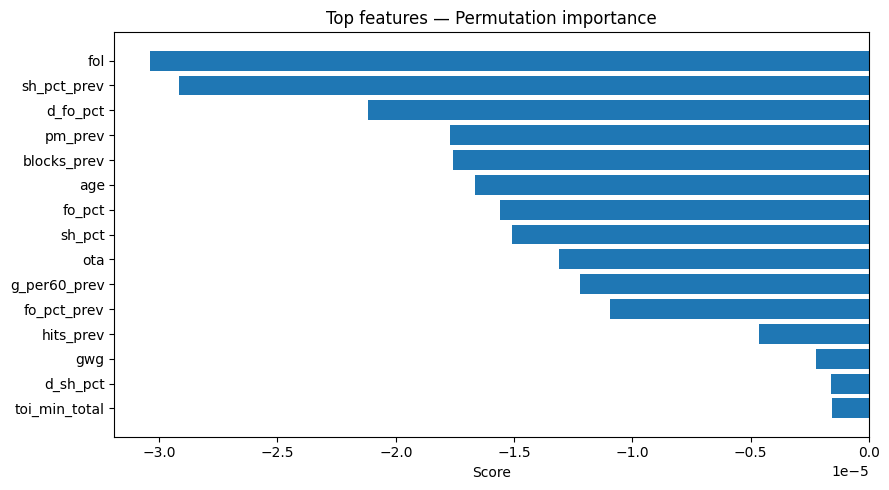

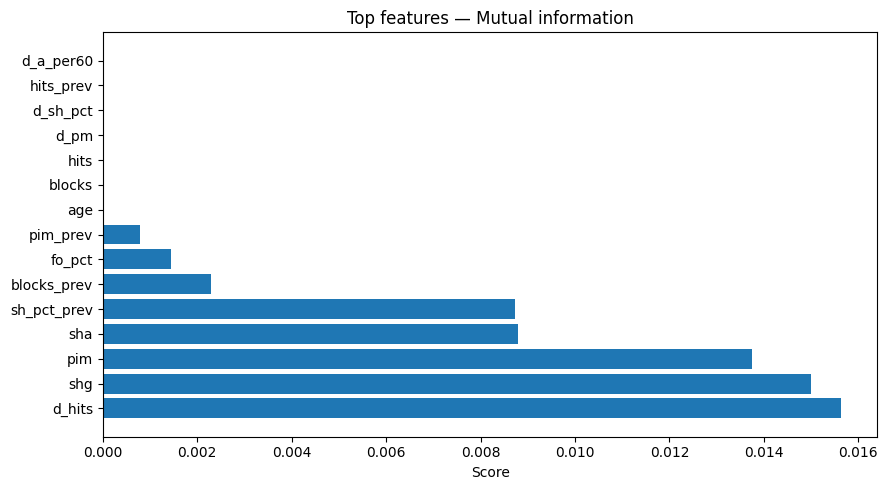

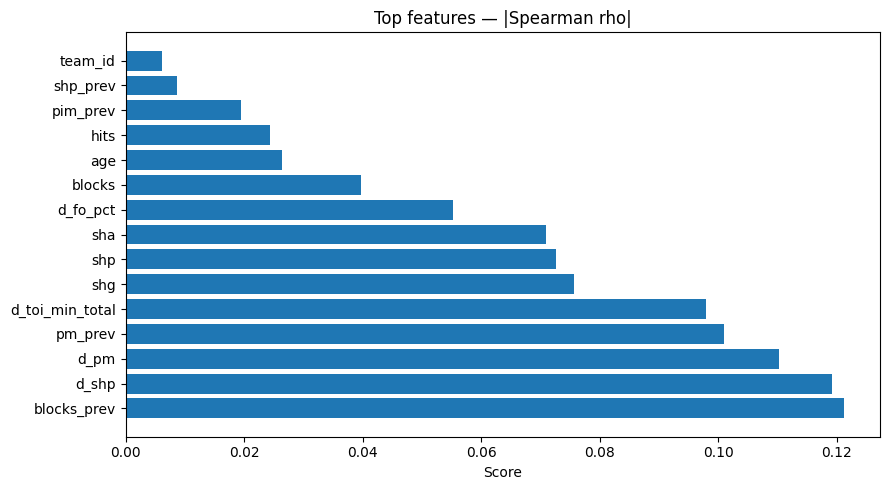

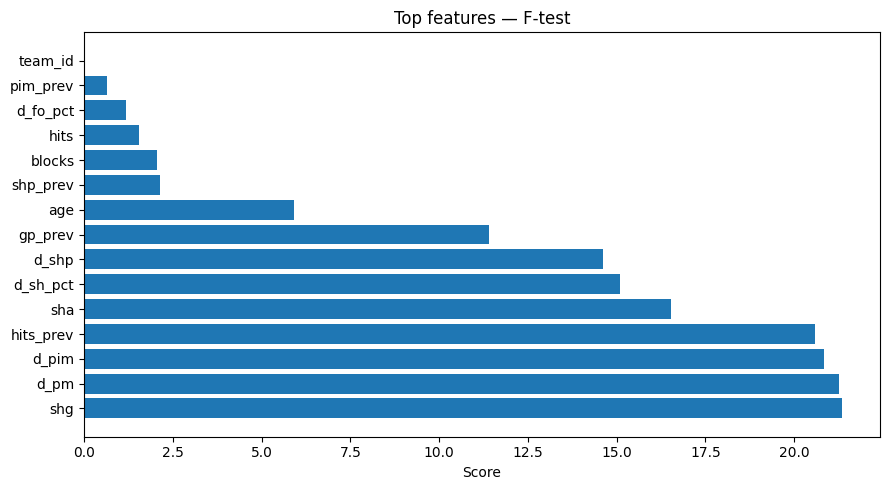

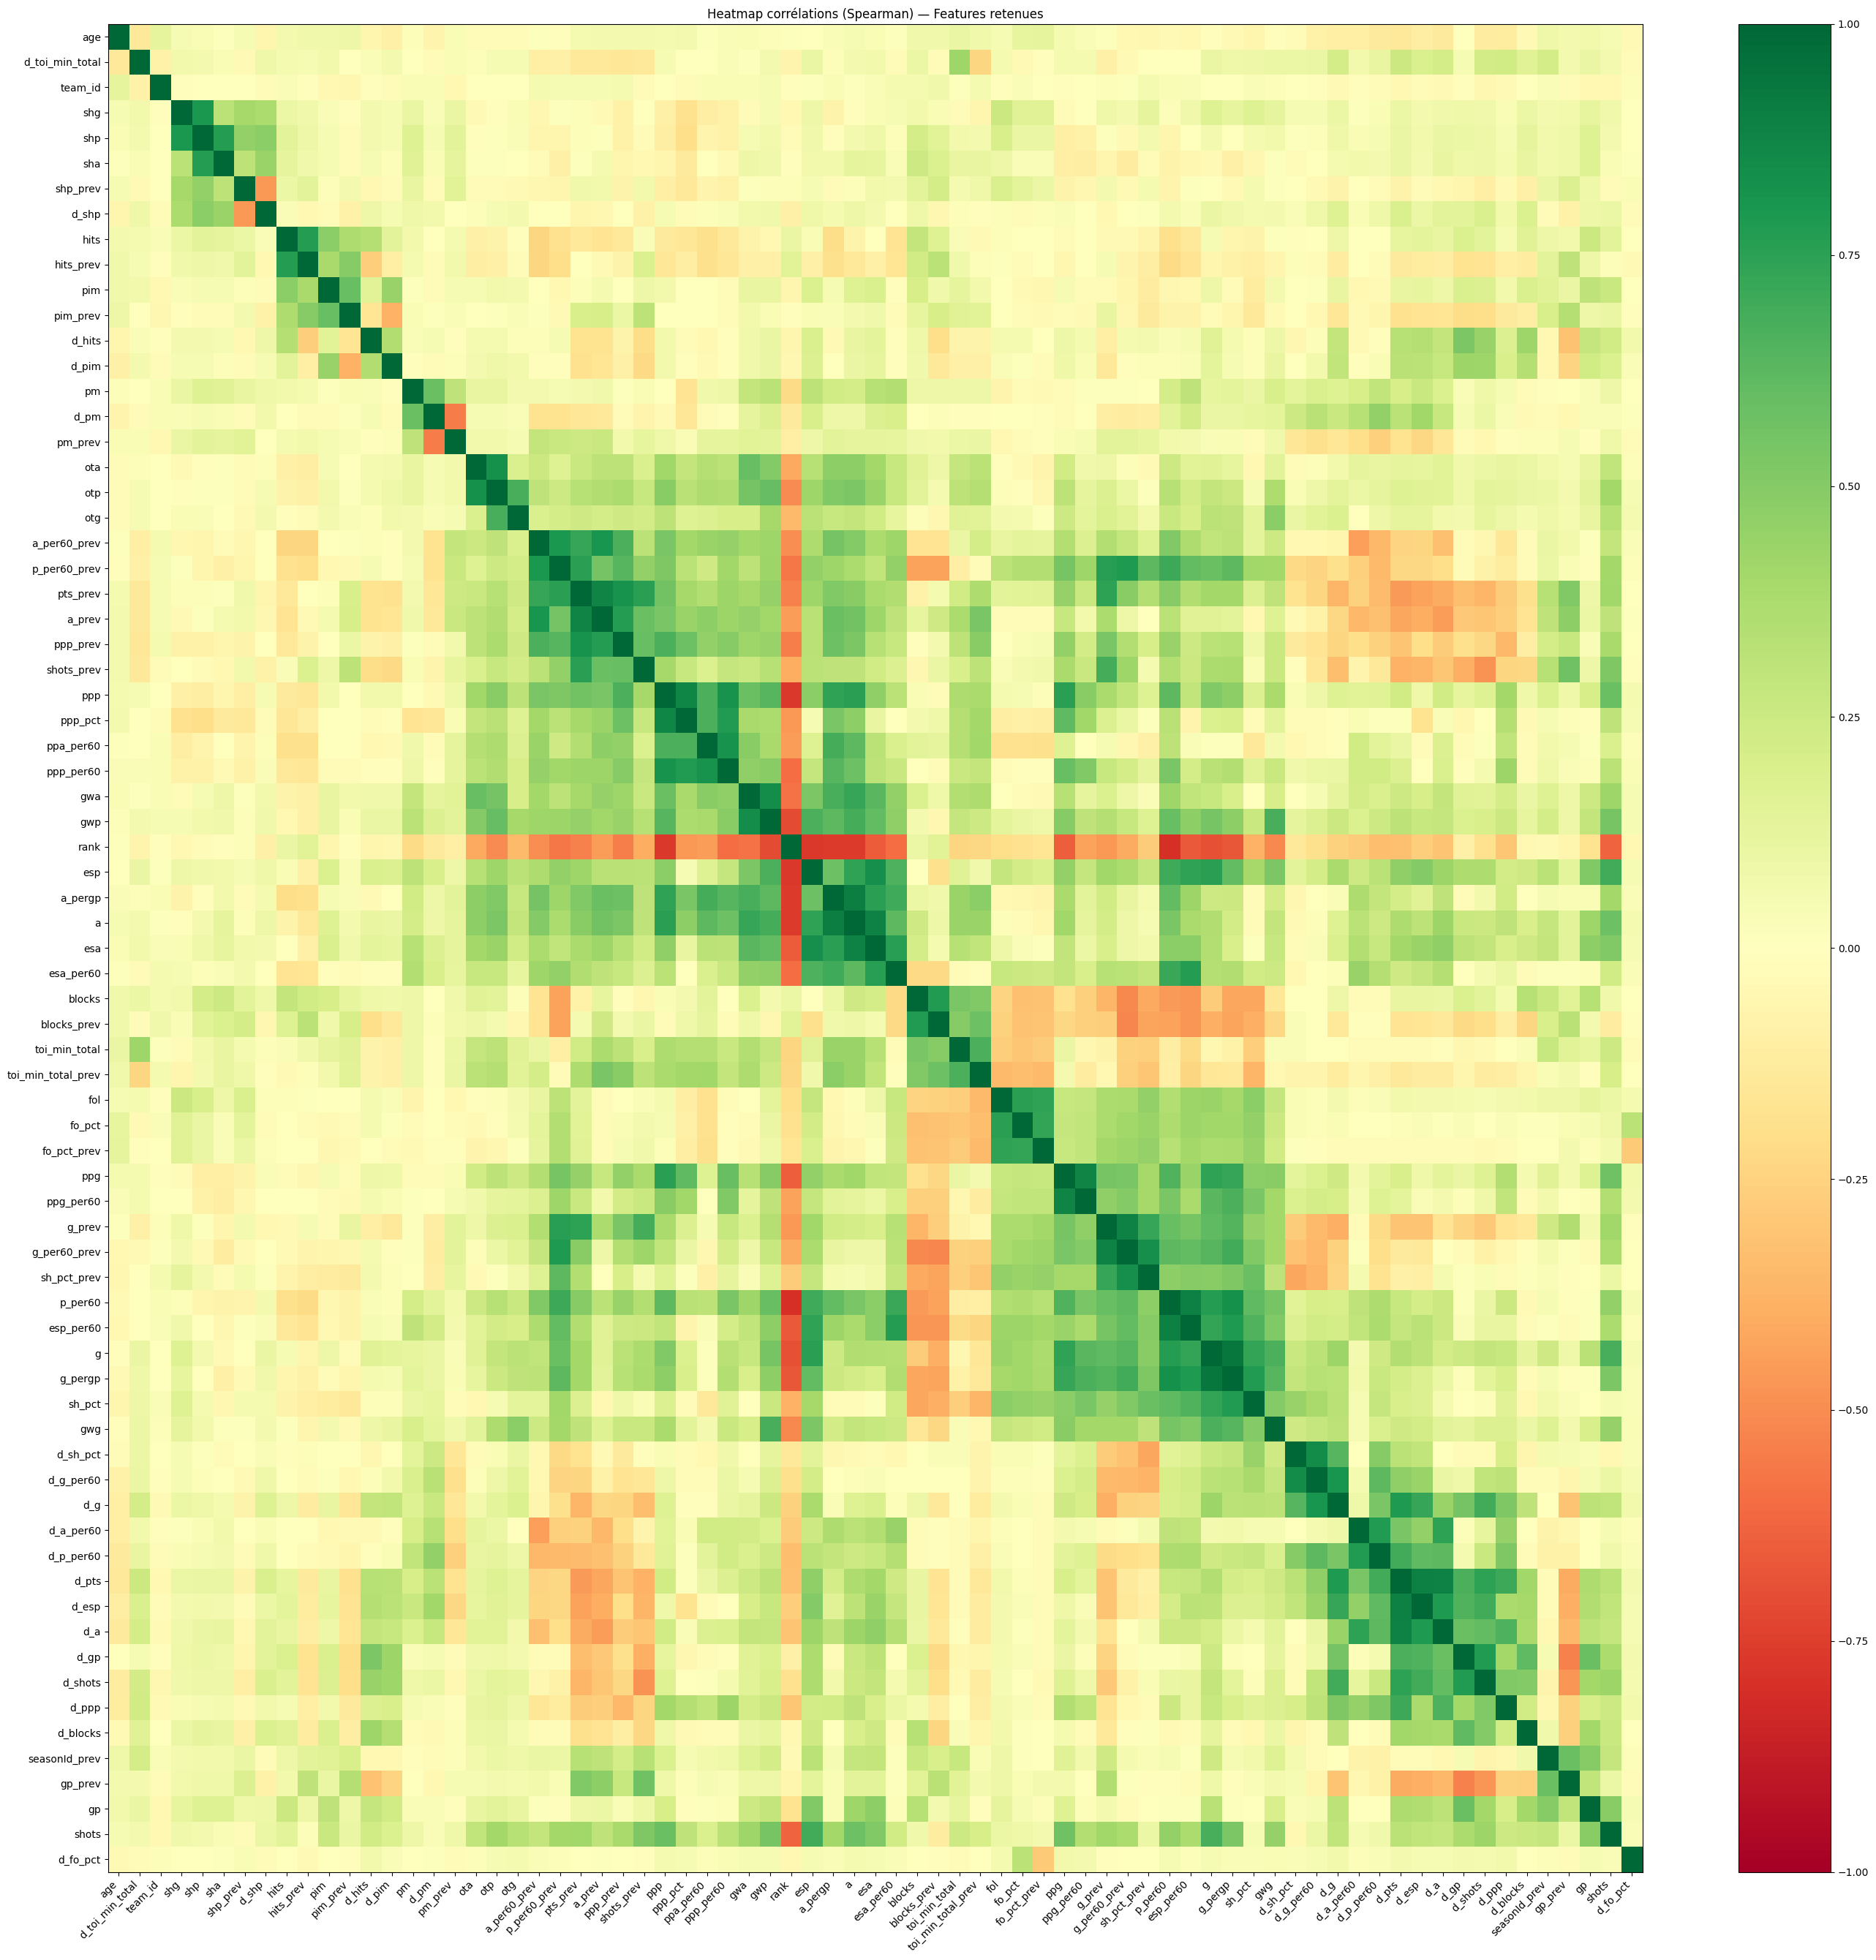

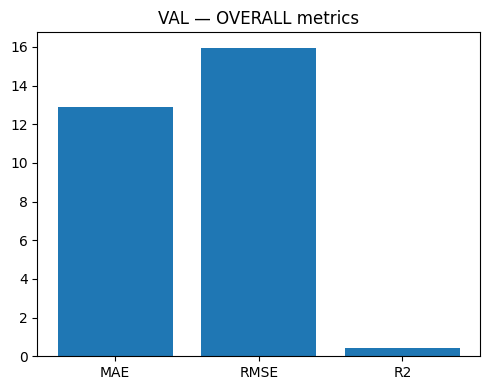

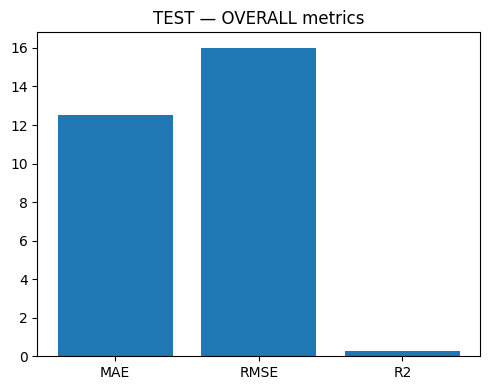

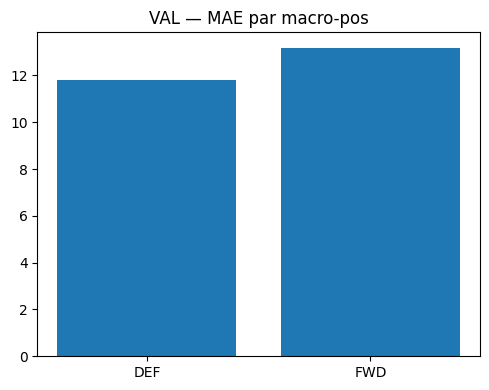

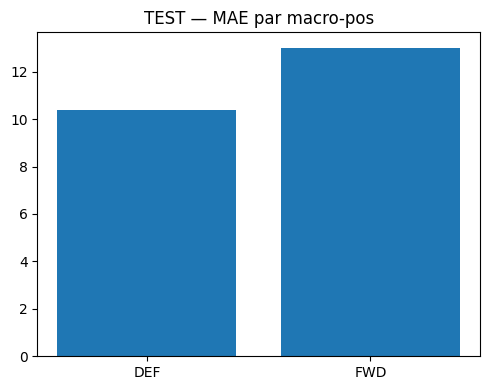

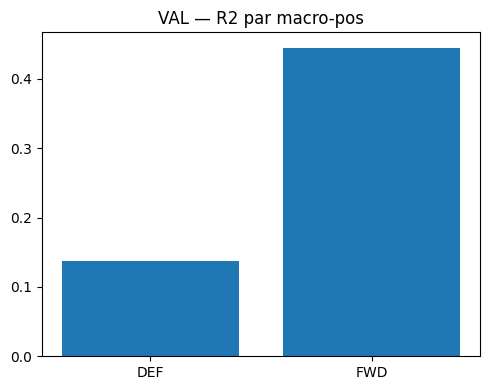

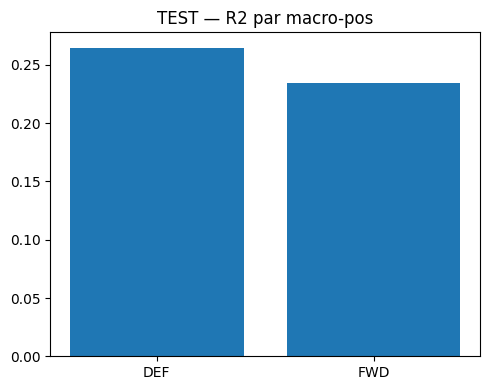

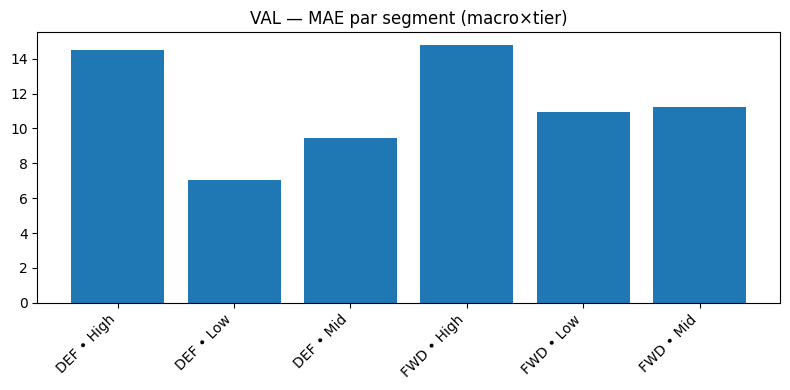

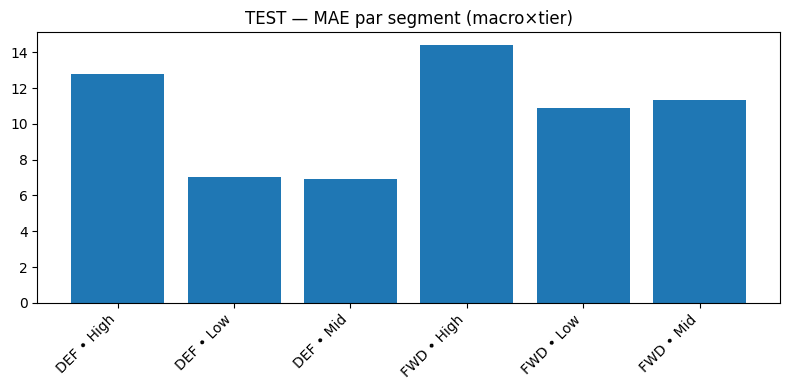

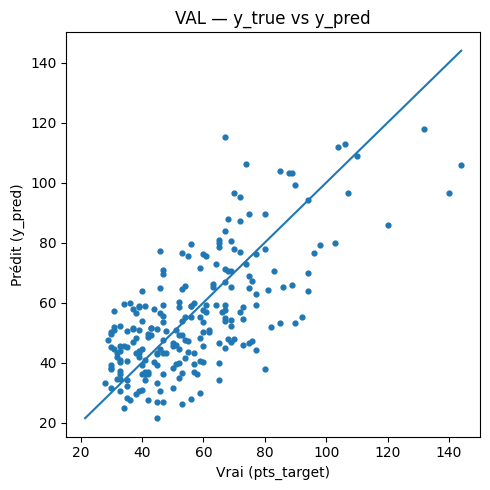

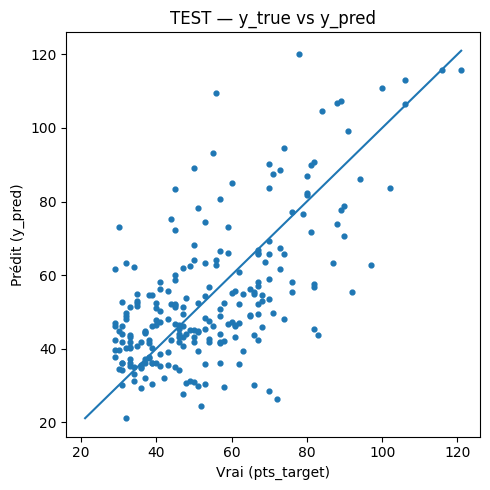

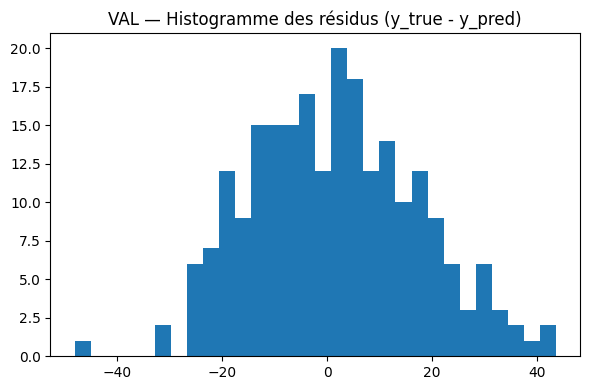

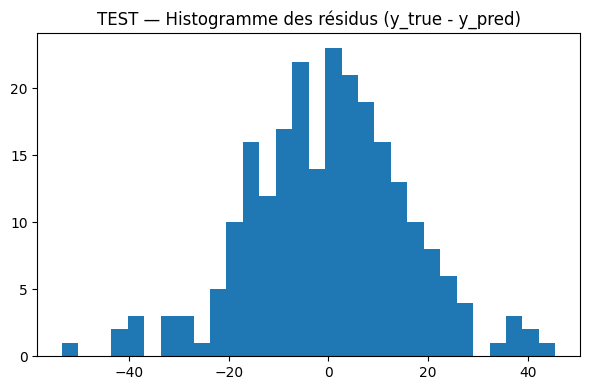

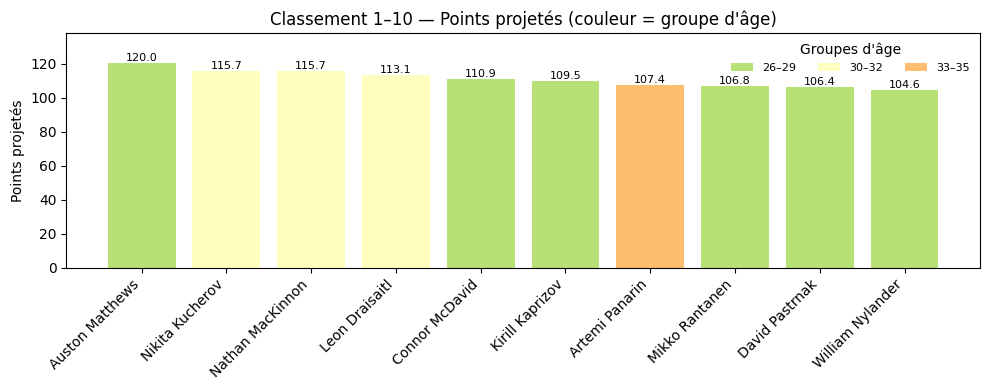

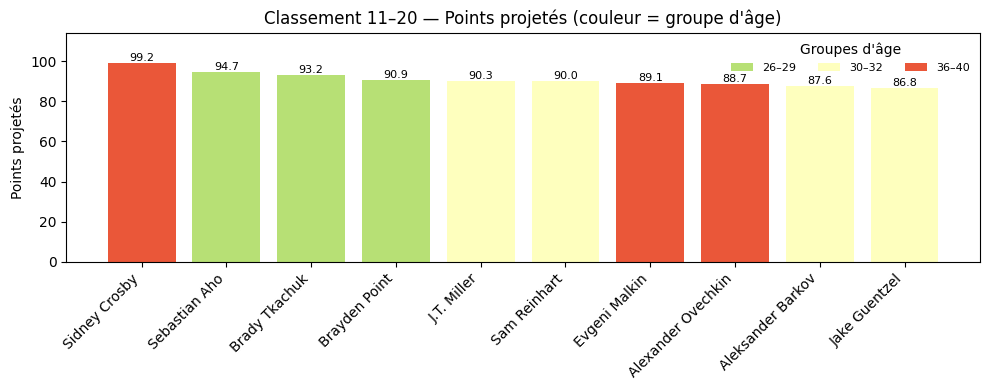

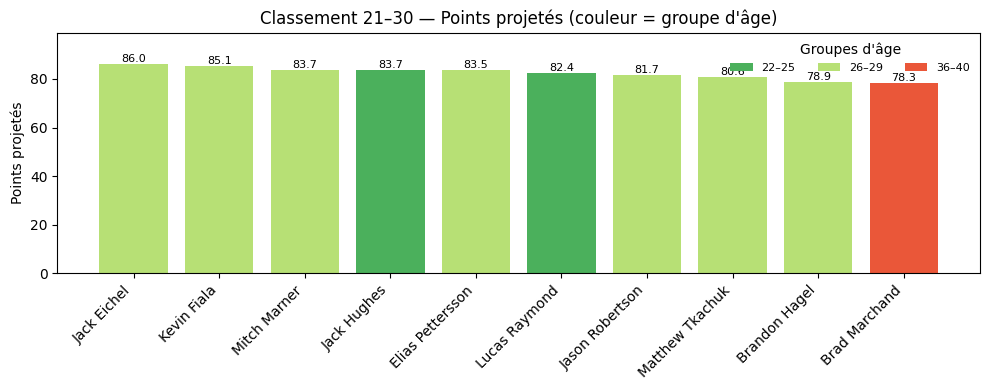

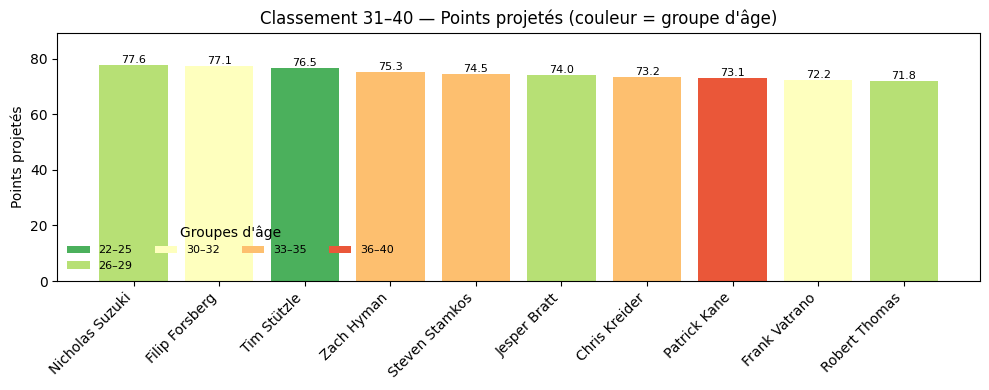

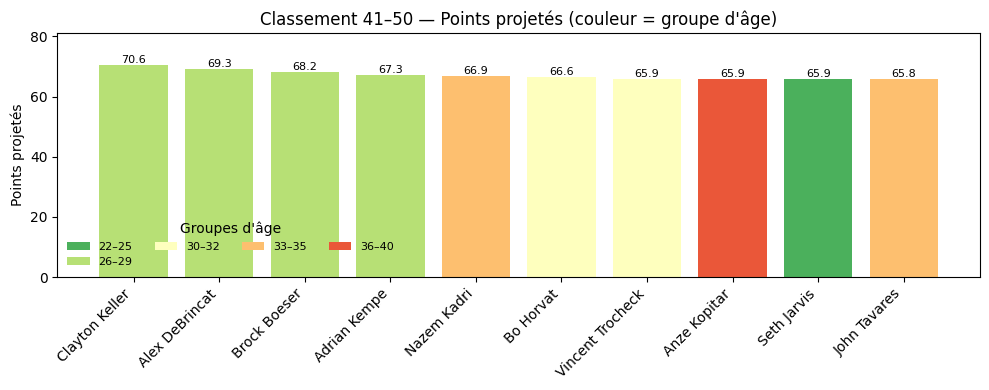

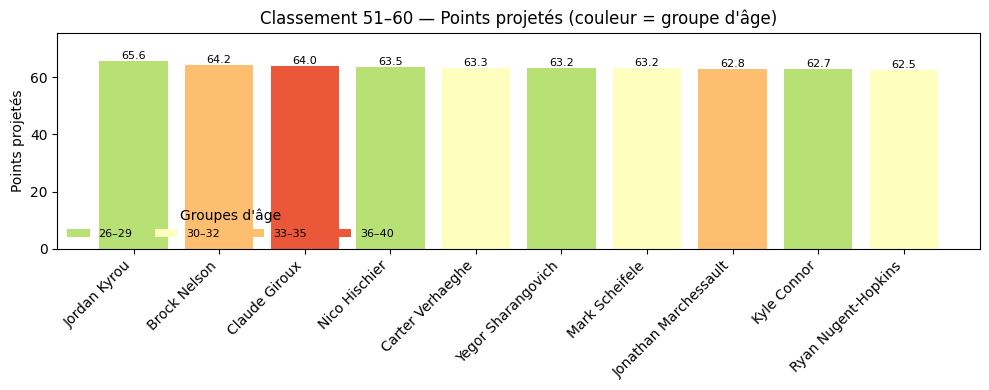

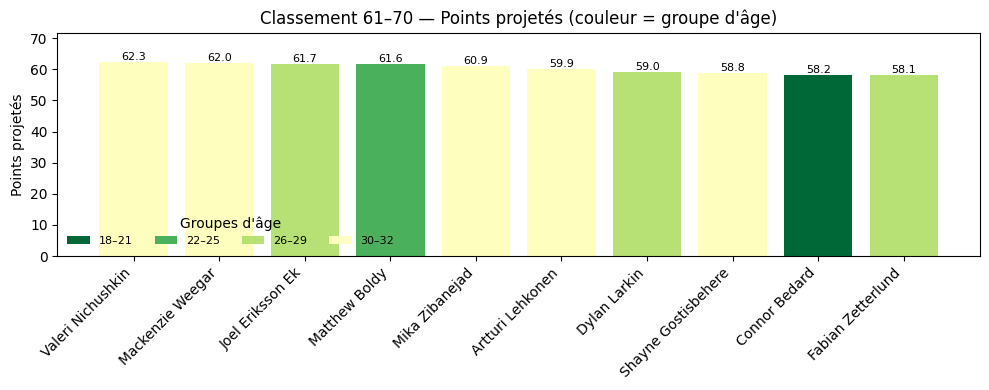

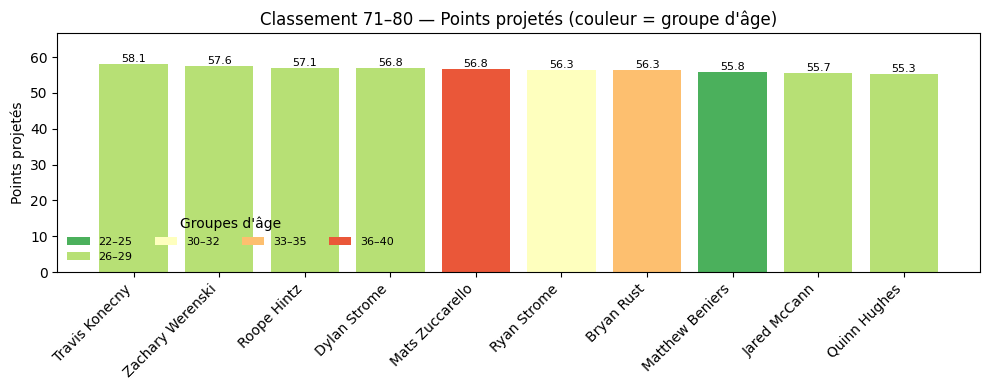

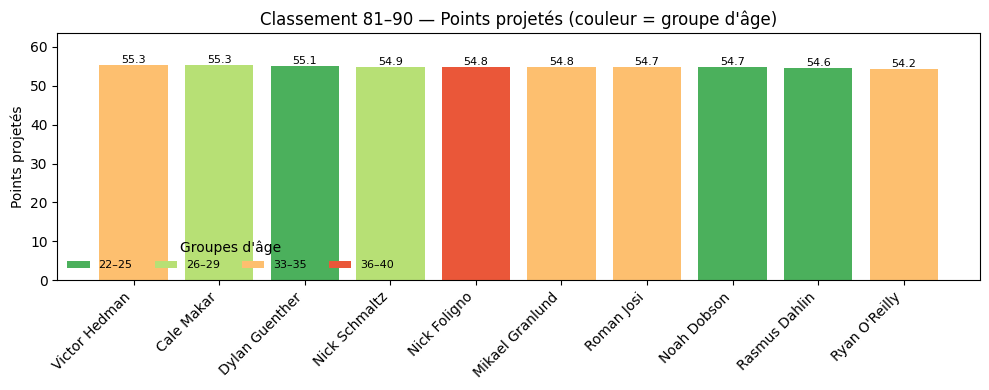

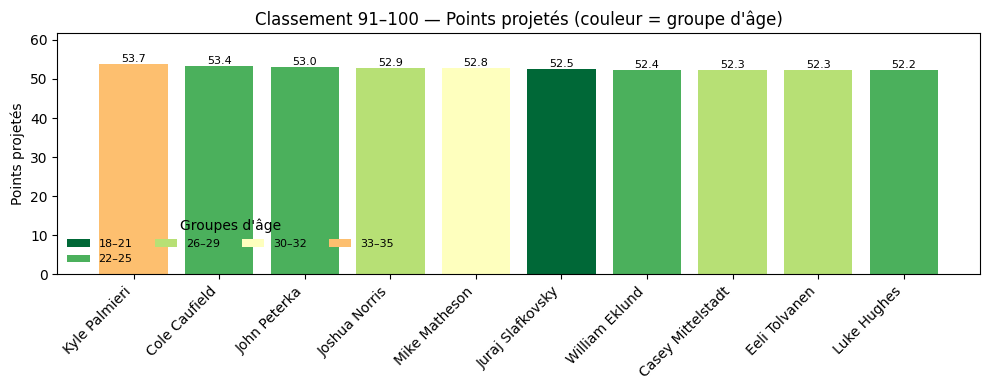

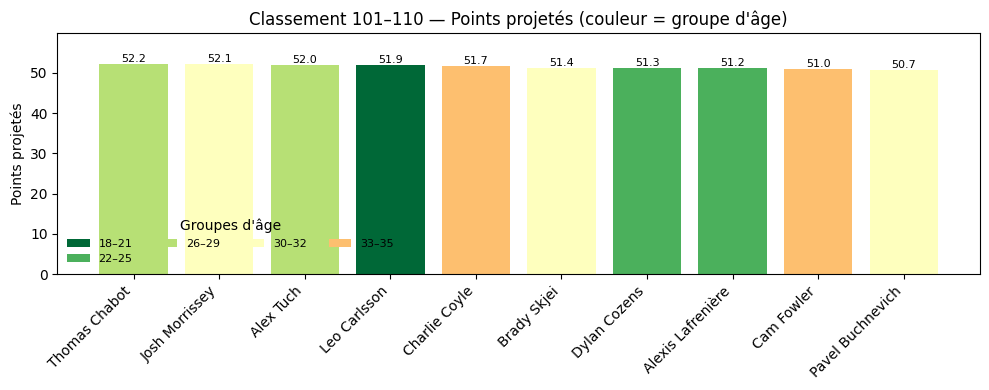

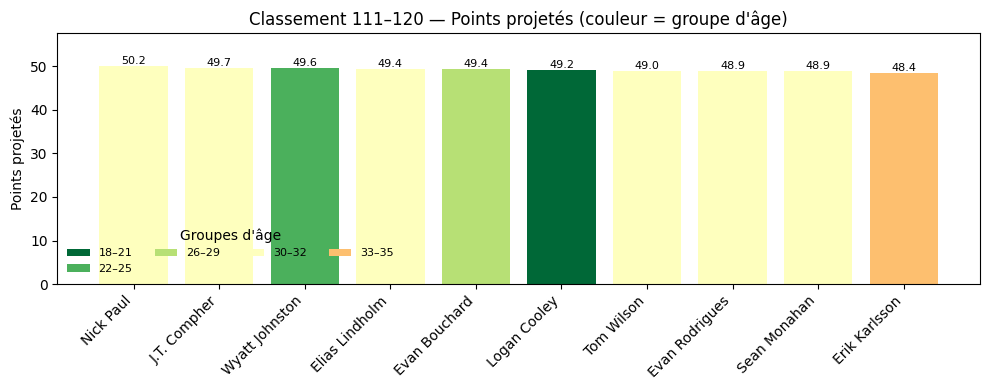

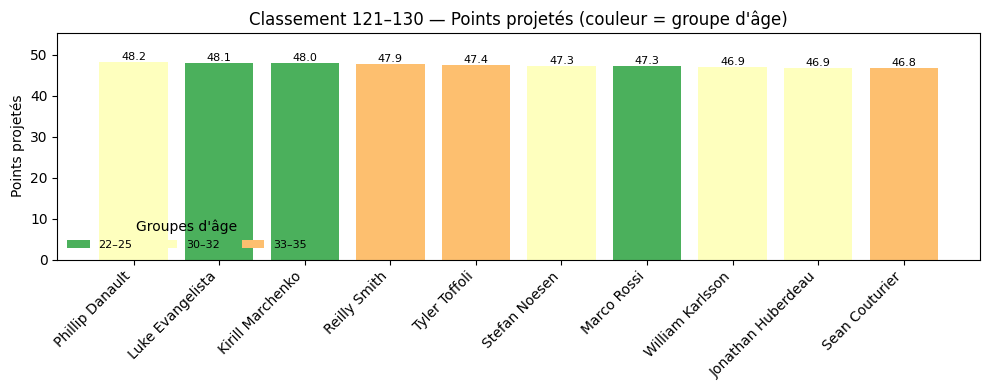

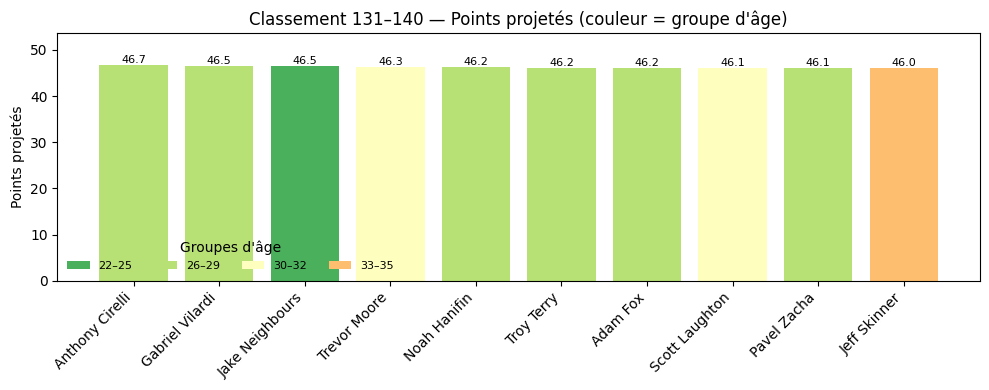

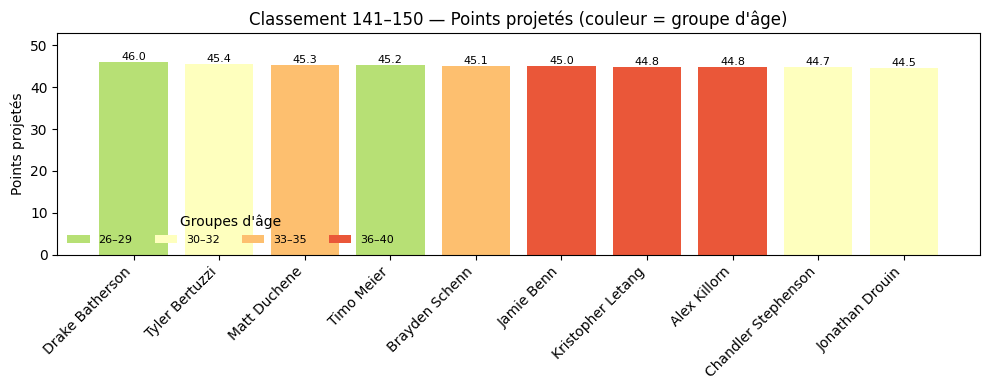

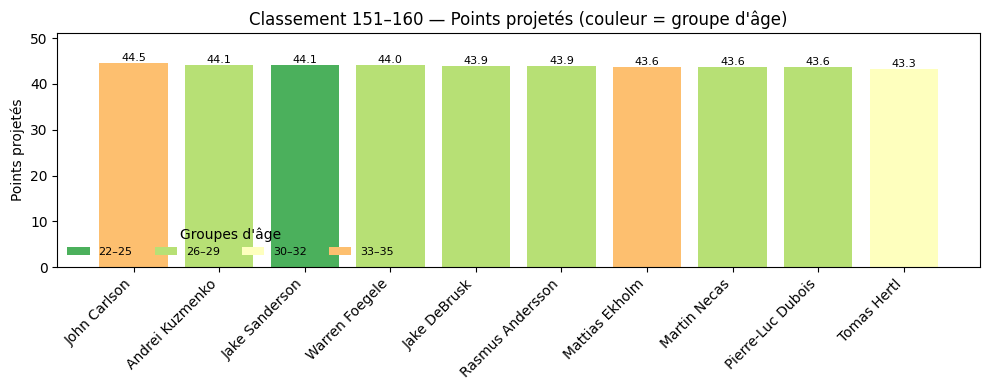

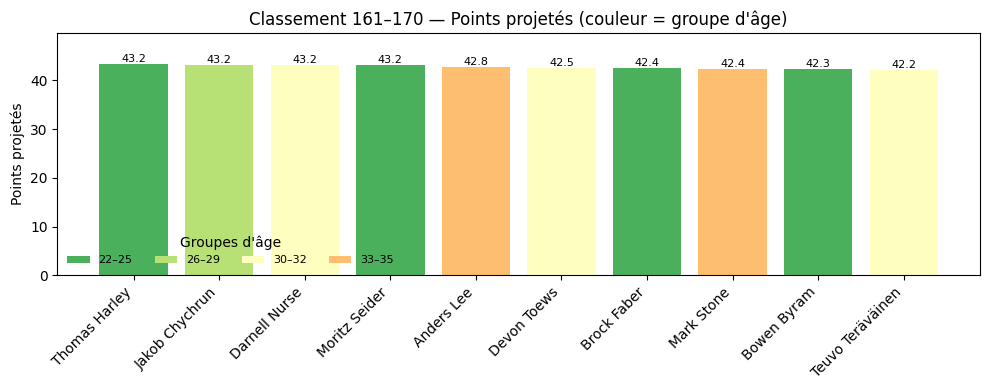

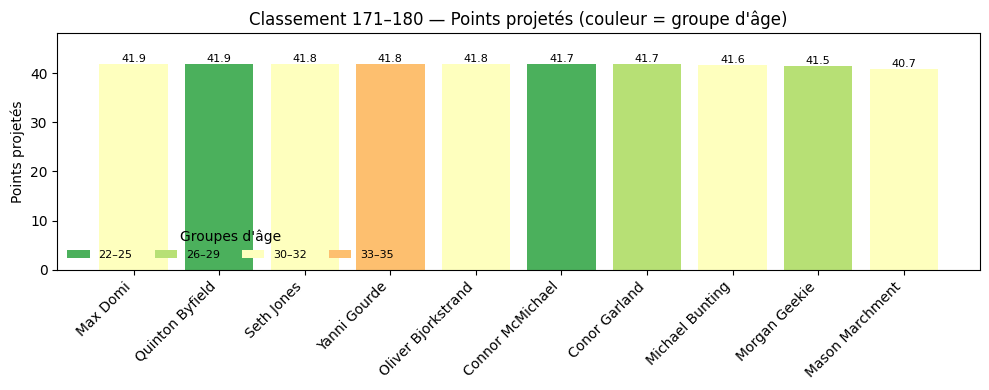

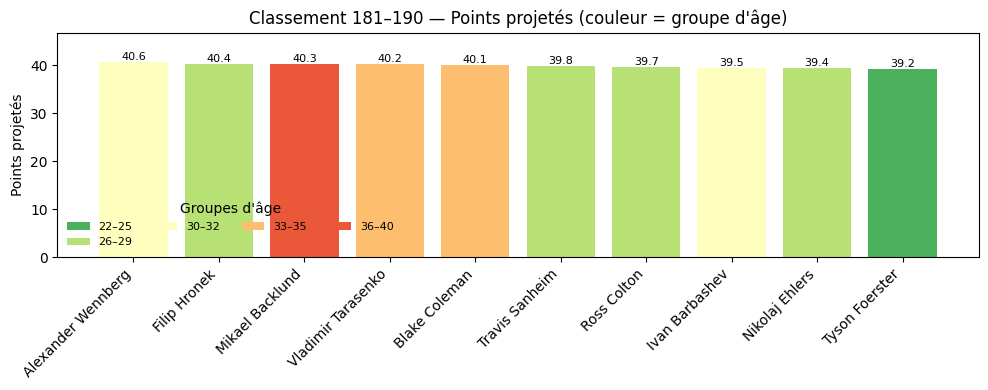

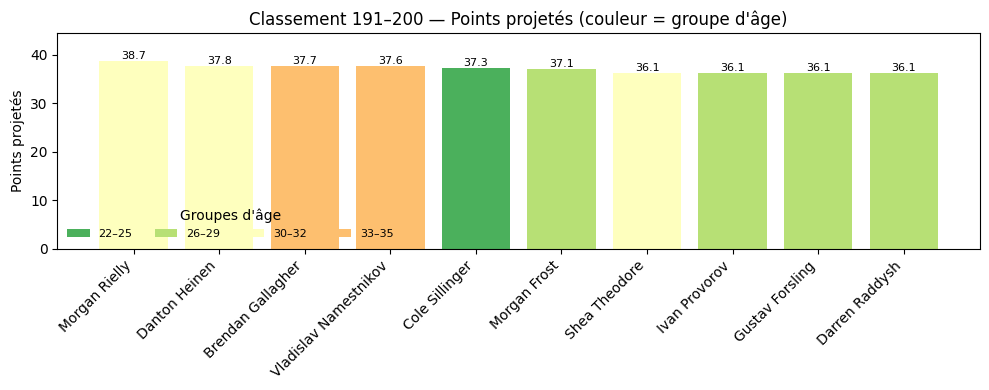

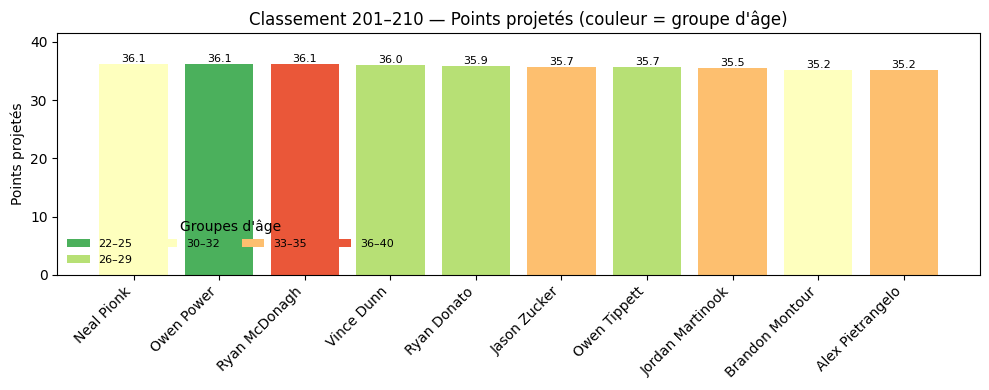

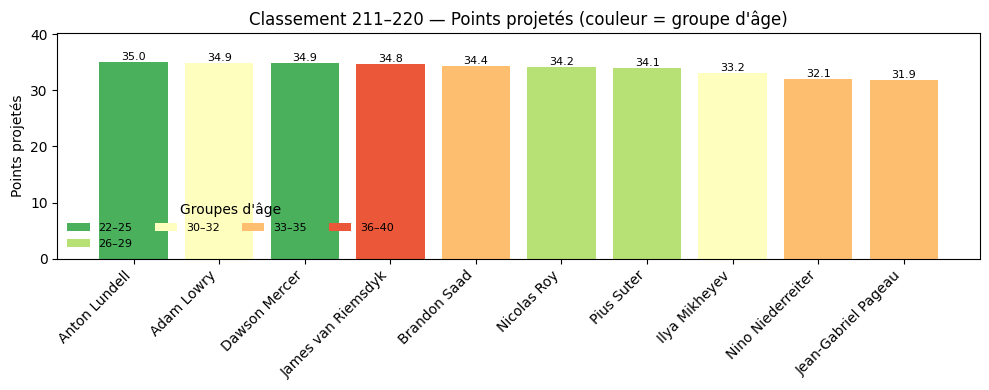

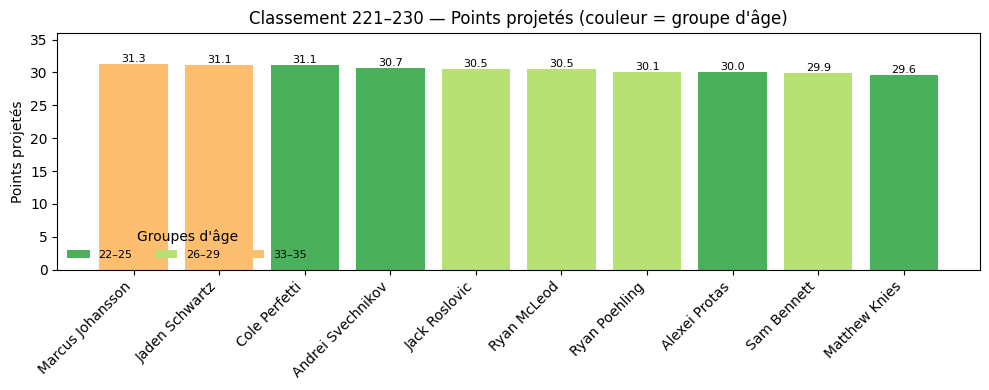

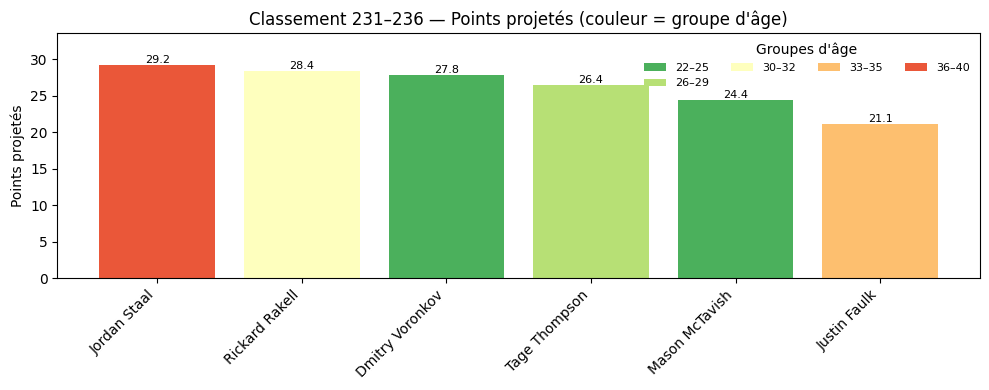

[OK] Excel écrit -> artifacts_models/projections_202526_avec_historiques.xlsx
[OK] PDF des graphiques enregistré -> artifacts_models/rapport_graphs_bloc6.pdf


In [115]:

#  GRAPHIQUES — Sélection de variables

def bar_top_from_long(df_long, metric_name, title, top_n=TOP_N, ascending=False):
    if df_long is None or df_long.empty:
        print(f"[Info] Pas de données pour {title}")
        return
    d = df_long[df_long["metric"] == metric_name].copy()
    if d.empty:
        print(f"[Info] Metric '{metric_name}' absente.")
        return
    d["score_plot"] = d["score"].abs() if metric_name == "spearman_rho" else d["score"]
    d = d.sort_values("score_plot", ascending=ascending).tail(top_n)
    plt.figure(figsize=(9, 5))
    plt.barh(d["feature"], d["score_plot"])
    plt.xlabel("Score")
    plt.title(title)
    plt.tight_layout()
    add_page()
    plt.show()

# 1) Permutation importance
bar_top_from_long(fs_long, "perm_importance", "Top features — Permutation importance")

# 2) Mutual information
bar_top_from_long(fs_long, "mutual_info", "Top features — Mutual information")

# 3) Spearman |rho|
bar_top_from_long(fs_long, "spearman_rho", "Top features — |Spearman rho|")

# 4) F-test
bar_top_from_long(fs_long, "f_test", "Top features — F-test")

# 5) Heatmap corrélation (GLOBAL) sur les features représentantes (si df en RAM)
try:
    if feat_rep is not None and "df" in globals():
        feats = [f for f in feat_rep["feature"].tolist() if f in df.columns]
        if len(feats) >= 2:
            Xcorr = df[feats].corr(method="spearman", numeric_only=True)
            plt.figure(figsize=(6 + 0.3*len(feats), 5 + 0.3*len(feats)))
            plt.imshow(Xcorr, aspect="auto", cmap="RdYlGn", vmin=-1, vmax=1)  # rouge->vert
            plt.xticks(ticks=range(len(feats)), labels=feats, rotation=45, ha="right")
            plt.yticks(ticks=range(len(feats)), labels=feats)
            plt.title("Heatmap corrélations (Spearman) — Features retenues")
            plt.colorbar()
            plt.tight_layout()
            add_page()
            plt.show()
        else:
            print("[Info] Trop peu de features retenues pour la heatmap.")
    else:
        print("[Info] Heatmap ignorée (feat_rep ou df non disponible).")
except Exception as e:
    print("[Info] Heatmap non tracée:", e)


#  GRAPHIQUES — Résultats finaux (val/test)

def plot_metrics_overall(met_df, split_name):
    if met_df is None or met_df.empty:
        print(f"[Info] metrics {split_name} indisponible")
        return
    d = met_df[met_df["level"] == "OVERALL"].copy()
    if d.empty:
        print(f"[Info] Pas de ligne OVERALL pour {split_name}")
        return
    row = d.iloc[0]
    names = ["MAE","RMSE","R2"]
    vals  = [row.get("MAE", np.nan), row.get("RMSE", np.nan), row.get("R2", np.nan)]
    plt.figure(figsize=(5,4))
    plt.bar(names, vals)
    plt.title(f"{split_name.upper()} — OVERALL metrics")
    plt.tight_layout()
    add_page()
    plt.show()

def plot_metrics_macro(met_df, split_name, metric="MAE"):
    if met_df is None or met_df.empty:
        print(f"[Info] metrics {split_name} indisponible")
        return
    d = met_df[met_df["level"] == "MACRO"].copy()
    if d.empty:
        print(f"[Info] Pas de lignes MACRO pour {split_name}")
        return
    d = d.sort_values("macro_pos")
    plt.figure(figsize=(5,4))
    plt.bar(d["macro_pos"], d[metric])
    plt.title(f"{split_name.upper()} — {metric} par macro-pos")
    plt.tight_layout()
    add_page()
    plt.show()

def plot_metrics_segments(met_df, split_name, metric="MAE"):
    if met_df is None or met_df.empty:
        print(f"[Info] metrics {split_name} indisponible")
        return
    d = met_df[met_df["level"] == "SEG"].copy()
    if d.empty:
        print(f"[Info] Pas de lignes SEGMENT pour {split_name} (petits n ou fallback global).")
        return
    d["key"] = d["macro_pos"].astype(str) + " • " + d["tier"].astype(str)
    d = d.sort_values(["macro_pos","tier"])
    plt.figure(figsize=(8,4))
    plt.bar(d["key"], d[metric])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{split_name.upper()} — {metric} par segment (macro×tier)")
    plt.tight_layout()
    add_page()
    plt.show()

# OVERALL (val & test)
plot_metrics_overall(met_val, "val")
plot_metrics_overall(met_test, "test")

#MACRO FWD/DEF (val & test) — MAE puis R2
plot_metrics_macro(met_val, "val", metric="MAE")
plot_metrics_macro(met_test, "test", metric="MAE")

plot_metrics_macro(met_val, "val", metric="R2")
plot_metrics_macro(met_test, "test", metric="R2")

# SEGMENTS (macro×tier) si disponibles
plot_metrics_segments(met_val, "val", metric="MAE")
plot_metrics_segments(met_test, "test", metric="MAE")

#  Nuages y_true vs y_pred (val & test)
def scatter_true_pred(pred_df, split_name):
    if pred_df is None or pred_df.empty or "pts_target" not in pred_df.columns or "y_pred" not in pred_df.columns:
        print(f"[Info] predictions {split_name} indisponible ou colonnes manquantes")
        return
    plt.figure(figsize=(5,5))
    plt.scatter(pred_df["pts_target"], pred_df["y_pred"], s=12)
    mn = float(np.nanmin([pred_df["pts_target"].min(), pred_df["y_pred"].min()]))
    mx = float(np.nanmax([pred_df["pts_target"].max(), pred_df["y_pred"].max()]))
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Vrai (pts_target)")
    plt.ylabel("Prédit (y_pred)")
    plt.title(f"{split_name.upper()} — y_true vs y_pred")
    plt.tight_layout()
    add_page()
    plt.show()

scatter_true_pred(pred_val, "val")
scatter_true_pred(pred_test, "test")

# Histogrammes des résidus (val & test)
def hist_residuals(pred_df, split_name):
    if pred_df is None or pred_df.empty or "pts_target" not in pred_df.columns or "y_pred" not in pred_df.columns:
        print(f"[Info] predictions {split_name} indisponible ou colonnes manquantes")
        return
    res = pred_df["pts_target"] - pred_df["y_pred"]
    plt.figure(figsize=(6,4))
    plt.hist(res.dropna().values, bins=30)
    plt.title(f"{split_name.upper()} — Histogramme des résidus (y_true - y_pred)")
    plt.tight_layout()
    add_page()
    plt.show()

hist_residuals(pred_val, "val")
hist_residuals(pred_test, "test")

def find_latest_predictions_next(model_dir):
    if not model_dir or not os.path.exists(model_dir):
        return None
    files = [f for f in os.listdir(model_dir) if f.startswith("predictions_next_") and f.endswith(".csv")]
    if not files:
        return None
    seasons = []
    for f in files:
        m = re.search(r'predictions_next_(\d+)\.csv$', f)
        if m:
            seasons.append((int(m.group(1)), f))
    if seasons:
        seasons.sort()
        return os.path.join(model_dir, seasons[-1][1])
    return os.path.join(model_dir, files[0])

pred_next_path = find_latest_predictions_next(MODEL_DIR)
pred_next = safe_read_csv(pred_next_path)

if pred_next is None or pred_next.empty:
    print("[Info] Aucune prédiction 'predictions_next_*.csv' trouvée.")
else:
    # --Déduire saisons next/test/prev à partir du nom de fichier
    m = re.search(r'predictions_next_(\d+)\.csv$', os.path.basename(pred_next_path))
    next_season = int(m.group(1)) if m else None
    test_season = next_season - 101 if next_season else None
    prev_season = test_season - 101 if test_season else None

    # Ajoute l'âge pour la saison suivante (âge de la saison test + 1), si df dispo
    pred_enriched = pred_next.copy()
    if "df" in globals() and test_season is not None and "age" in df.columns:
        ages = (df[df["seasonId"] == test_season][["playerName", "age"]]
                .drop_duplicates())
        ages["age_next"] = pd.to_numeric(ages["age"], errors="coerce") + 1
        pred_enriched = pred_enriched.merge(ages[["playerName","age_next"]], on="playerName", how="left")
    else:
        pred_enriched["age_next"] = np.nan

    #  Groupes d'âge
    def age_band_fn(a):
        if pd.isna(a): return "N/A"
        a = int(a)
        if a <= 21: return "18–21"
        elif a <= 25: return "22–25"
        elif a <= 29: return "26–29"
        elif a <= 32: return "30–32"
        elif a <= 35: return "33–35"
        elif a <= 40: return "36–40"
        else: return "40+"

    pred_enriched["age_band"] = pred_enriched["age_next"].apply(age_band_fn)
    band_order = ["18–21","22–25","26–29","30–32","33–35","36–40","40+"]
    cmap = plt.cm.get_cmap("RdYlGn")
    band_to_color = {b: cmap(v) for b, v in zip(band_order, np.linspace(1, 0, len(band_order)))}
    fallback_grey = (0.6, 0.6, 0.6, 1.0)

    #  Classement global & groupes de 10
    topN = min(250, len(pred_enriched))
    top = (pred_enriched.sort_values("y_pred", ascending=False)
           .head(topN).reset_index(drop=True))
    top["rank"]  = np.arange(1, len(top)+1)
    top["group"] = ((top["rank"] - 1) // 10) + 1

    # ---- 25 graphiques (ou moins si <250 joueurs)
    num_groups = int(top["group"].max())
    for g in range(1, min(25, num_groups) + 1):
        sg = top[top["group"] == g]
        colors = [band_to_color.get(b, fallback_grey) for b in sg["age_band"]]

        plt.figure(figsize=(10, 4))
        bars = plt.bar(sg["playerName"], sg["y_pred"], color=colors)

        # Data labels (points projetés)
        ymax = float(sg["y_pred"].max()) if len(sg) else 0.0
        for bar, val in zip(bars, sg["y_pred"]):
            plt.text(bar.get_x() + bar.get_width()/2,
                     bar.get_height(),
                     f"{val:.1f}",
                     ha="center", va="bottom", fontsize=8)
        plt.ylim(0, max(1.0, ymax*1.15))

        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Points projetés")
        r1 = (g-1)*10 + 1; r2 = min(g*10, topN)
        plt.title(f"Classement {r1}–{r2} — Points projetés (couleur = groupe d'âge)")

        # Légende (groupes d'âge présents)
        present_bands = [b for b in band_order if b in sg["age_band"].unique()]
        handles = [Patch(facecolor=band_to_color[b], label=b) for b in present_bands]
        if handles:
            plt.legend(handles=handles, title="Groupes d'âge", ncol=4, frameon=False, fontsize=8)

        plt.tight_layout()
        add_page()
        plt.show()

    # Excel: nom, âge (next), points projetés, points 2025 & 2024 (réels si dispo)
    def actual_pts(df_base, season_id):
        return (df_base[df_base["seasonId"] == season_id][["playerName", "pts"]]
                .drop_duplicates()
                .rename(columns={"pts": f"pts_{season_id}"}))

    out = top.copy()

    # Ajoute âges (next) si pas déjà fait
    if "age_next" not in out.columns:
        out["age_next"] = np.nan

    # Points réels 2025 (2024-25) & 2024 (2023-24)
    if "df" in globals() and test_season is not None:
        out = out.merge(actual_pts(df, test_season), on="playerName", how="left")
    if "df" in globals() and prev_season is not None:
        out = out.merge(actual_pts(df, prev_season), on="playerName", how="left")

    def endyear_label(season_id):
        s = str(season_id)
        return 2000 + int(s[-2:])

    col_2025 = f"pts_{test_season}" if test_season is not None else None
    col_2024 = f"pts_{prev_season}" if prev_season is not None else None
    rename_map = {"y_pred": "points_projetes", "age_next": "age"}
    if col_2025 and col_2025 in out.columns:
        rename_map[col_2025] = f"points_{endyear_label(test_season)}"
    if col_2024 and col_2024 in out.columns:
        rename_map[col_2024] = f"points_{endyear_label(prev_season)}"

    out_final = out.rename(columns=rename_map)

    keep_cols = ["playerName", "age", "points_projetes"]
    if f"points_{endyear_label(test_season)}" in out_final.columns:
        keep_cols.append(f"points_{endyear_label(test_season)}")
    if f"points_{endyear_label(prev_season)}" in out_final.columns:
        keep_cols.append(f"points_{endyear_label(prev_season)}")
    out_final = out_final[keep_cols]

    excel_path = os.path.join(MODEL_DIR, f"projections_{next_season}_avec_historiques.xlsx")
    try:
        with pd.ExcelWriter(excel_path, engine="xlsxwriter") as xl:
            out_final.to_excel(xl, "projections", index=False)
        print(f"[OK] Excel écrit -> {excel_path}")
    except Exception as e:
        print("[Info] Excel non écrit:", e)

#PDF
try:
    pdf.close()
    print(f"[OK] PDF des graphiques enregistré -> {PDF_PATH}")
except Exception as e:
    print("[Info] PDF non écrit:", e)